# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 50 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')

In [6]:
np.shape(varftrain)

(7000, 10, 2, 50)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')

In [10]:
np.shape(varftest)

(1000, 10, 2, 50)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')

In [14]:
np.shape(varfval)

(2000, 10, 2, 50)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 50), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 50
SHUFFLE_BUFFER_SIZE = 50

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)
#model = Sequential()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,2,50)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(12, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation = custom_activation)
])


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 50)                50050     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 12)                312       
                                                                 
 dense_3 (Dense)             (None, 25)                325       
                                                        

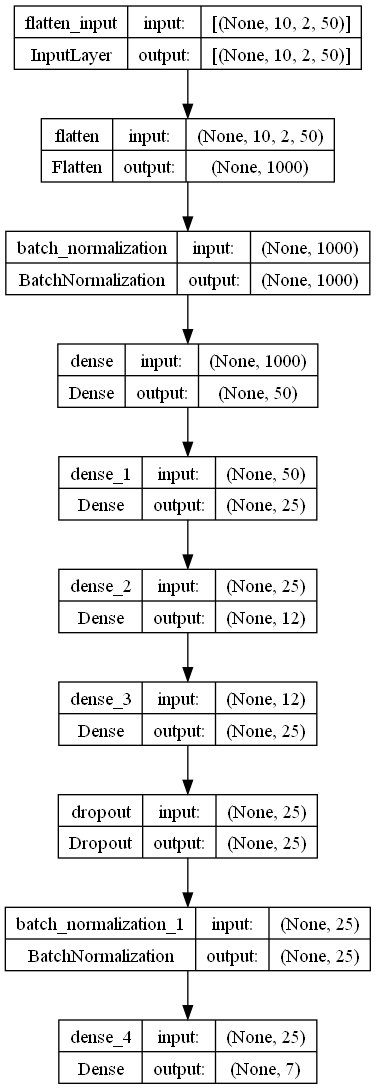

In [22]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [23]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [24]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [25]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [26]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [27]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, 
                    callbacks=[reduce_lr, early_stop])

Epoch 1/1000
140/140 [==============================] - 1s 3ms/step - loss: 11.6496 - a_1: 2.9281 - a_2: 2.9758 - b_1: 2.7430 - b_2: 2.8049 - d_1: 1.7471 - d_2: 1.8885 - n: 2.3141 - mean_metric: 0.5723 - val_loss: 9.0923 - val_a_1: 2.6867 - val_a_2: 2.6988 - val_b_1: 2.4809 - val_b_2: 2.5924 - val_d_1: 1.5579 - val_d_2: 1.6329 - val_n: 1.5950 - val_mean_metric: 0.5013 - lr: 0.0010
Epoch 2/1000
140/140 [==============================] - 0s 2ms/step - loss: 9.6873 - a_1: 2.8014 - a_2: 2.8469 - b_1: 2.5480 - b_2: 2.6423 - d_1: 1.4023 - d_2: 1.5877 - n: 1.8094 - mean_metric: 0.5141 - val_loss: 8.3267 - val_a_1: 2.6590 - val_a_2: 2.6694 - val_b_1: 2.4326 - val_b_2: 2.5601 - val_d_1: 1.1547 - val_d_2: 1.3837 - val_n: 1.5739 - val_mean_metric: 0.4748 - lr: 0.0010
Epoch 3/1000
140/140 [==============================] - 0s 2ms/step - loss: 8.7873 - a_1: 2.7364 - a_2: 2.7851 - b_1: 2.4372 - b_2: 2.5350 - d_1: 1.2723 - d_2: 1.4382 - n: 1.6933 - mean_metric: 0.4897 - val_loss: 7.7847 - val_a_1: 2.

140/140 [==============================] - 0s 2ms/step - loss: 5.7895 - a_1: 2.5616 - a_2: 2.5730 - b_1: 1.9717 - b_2: 1.9923 - d_1: 0.8913 - d_2: 0.9530 - n: 1.4792 - mean_metric: 0.4082 - val_loss: 5.4451 - val_a_1: 2.4917 - val_a_2: 2.5459 - val_b_1: 1.8855 - val_b_2: 1.9424 - val_d_1: 0.7367 - val_d_2: 0.8294 - val_n: 1.4760 - val_mean_metric: 0.3918 - lr: 0.0010
Epoch 23/1000
140/140 [==============================] - 0s 2ms/step - loss: 5.7353 - a_1: 2.5693 - a_2: 2.5666 - b_1: 1.9485 - b_2: 1.9518 - d_1: 0.8927 - d_2: 0.9125 - n: 1.4812 - mean_metric: 0.4051 - val_loss: 5.4115 - val_a_1: 2.5033 - val_a_2: 2.5583 - val_b_1: 1.7828 - val_b_2: 2.0000 - val_d_1: 0.6825 - val_d_2: 0.7651 - val_n: 1.4755 - val_mean_metric: 0.3872 - lr: 0.0010
Epoch 24/1000
140/140 [==============================] - 0s 2ms/step - loss: 5.7284 - a_1: 2.5783 - a_2: 2.5408 - b_1: 1.9696 - b_2: 1.9442 - d_1: 0.9293 - d_2: 0.9233 - n: 1.4663 - mean_metric: 0.4059 - val_loss: 5.8276 - val_a_1: 2.5330 - val_a

140/140 [==============================] - 0s 2ms/step - loss: 5.3456 - a_1: 2.5398 - a_2: 2.5553 - b_1: 1.8748 - b_2: 1.8217 - d_1: 0.8416 - d_2: 0.8506 - n: 1.4643 - mean_metric: 0.3927 - val_loss: 4.9813 - val_a_1: 2.4785 - val_a_2: 2.5314 - val_b_1: 1.7682 - val_b_2: 1.7940 - val_d_1: 0.5501 - val_d_2: 0.6721 - val_n: 1.4618 - val_mean_metric: 0.3703 - lr: 0.0010
Epoch 44/1000
140/140 [==============================] - 0s 2ms/step - loss: 5.3334 - a_1: 2.5370 - a_2: 2.5486 - b_1: 1.8606 - b_2: 1.8178 - d_1: 0.8489 - d_2: 0.8563 - n: 1.4663 - mean_metric: 0.3923 - val_loss: 5.1247 - val_a_1: 2.4858 - val_a_2: 2.5451 - val_b_1: 1.7546 - val_b_2: 1.8824 - val_d_1: 0.5676 - val_d_2: 0.7528 - val_n: 1.4634 - val_mean_metric: 0.3768 - lr: 0.0010
Epoch 45/1000
140/140 [==============================] - 0s 2ms/step - loss: 5.2763 - a_1: 2.5421 - a_2: 2.5441 - b_1: 1.8404 - b_2: 1.7975 - d_1: 0.8289 - d_2: 0.8427 - n: 1.4683 - mean_metric: 0.3901 - val_loss: 5.3705 - val_a_1: 2.4958 - val_a

140/140 [==============================] - 0s 2ms/step - loss: 5.1733 - a_1: 2.5375 - a_2: 2.5584 - b_1: 1.8162 - b_2: 1.7656 - d_1: 0.8119 - d_2: 0.8202 - n: 1.4636 - mean_metric: 0.3870 - val_loss: 4.7664 - val_a_1: 2.4759 - val_a_2: 2.5290 - val_b_1: 1.6463 - val_b_2: 1.7677 - val_d_1: 0.5026 - val_d_2: 0.5814 - val_n: 1.4636 - val_mean_metric: 0.3608 - lr: 0.0010
Epoch 65/1000
140/140 [==============================] - 0s 2ms/step - loss: 5.1173 - a_1: 2.5297 - a_2: 2.5446 - b_1: 1.8055 - b_2: 1.7522 - d_1: 0.8043 - d_2: 0.8049 - n: 1.4650 - mean_metric: 0.3847 - val_loss: 4.9405 - val_a_1: 2.4600 - val_a_2: 2.5388 - val_b_1: 1.6115 - val_b_2: 2.0227 - val_d_1: 0.6271 - val_d_2: 0.6278 - val_n: 1.4595 - val_mean_metric: 0.3735 - lr: 0.0010
Epoch 66/1000
140/140 [==============================] - 0s 2ms/step - loss: 5.1276 - a_1: 2.5352 - a_2: 2.5562 - b_1: 1.7870 - b_2: 1.7701 - d_1: 0.7969 - d_2: 0.8200 - n: 1.4682 - mean_metric: 0.3857 - val_loss: 4.7623 - val_a_1: 2.4674 - val_a

140/140 [==============================] - 0s 2ms/step - loss: 4.9356 - a_1: 2.5397 - a_2: 2.5511 - b_1: 1.6976 - b_2: 1.6908 - d_1: 0.7831 - d_2: 0.7670 - n: 1.4611 - mean_metric: 0.3776 - val_loss: 4.7214 - val_a_1: 2.4599 - val_a_2: 2.5315 - val_b_1: 1.6421 - val_b_2: 1.8047 - val_d_1: 0.4759 - val_d_2: 0.6708 - val_n: 1.4598 - val_mean_metric: 0.3634 - lr: 0.0010
Epoch 86/1000
140/140 [==============================] - 0s 2ms/step - loss: 5.0031 - a_1: 2.5354 - a_2: 2.5471 - b_1: 1.7278 - b_2: 1.7607 - d_1: 0.7670 - d_2: 0.7924 - n: 1.4607 - mean_metric: 0.3810 - val_loss: 4.8023 - val_a_1: 2.4693 - val_a_2: 2.5393 - val_b_1: 1.5815 - val_b_2: 1.8636 - val_d_1: 0.5792 - val_d_2: 0.6306 - val_n: 1.4599 - val_mean_metric: 0.3660 - lr: 0.0010
Epoch 87/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.9567 - a_1: 2.5325 - a_2: 2.5535 - b_1: 1.6951 - b_2: 1.7185 - d_1: 0.7714 - d_2: 0.7826 - n: 1.4677 - mean_metric: 0.3786 - val_loss: 4.6211 - val_a_1: 2.4639 - val_a

140/140 [==============================] - 0s 2ms/step - loss: 4.8348 - a_1: 2.5207 - a_2: 2.5598 - b_1: 1.6243 - b_2: 1.6805 - d_1: 0.7540 - d_2: 0.7869 - n: 1.4573 - mean_metric: 0.3742 - val_loss: 4.6752 - val_a_1: 2.4649 - val_a_2: 2.5190 - val_b_1: 1.5539 - val_b_2: 1.8241 - val_d_1: 0.4383 - val_d_2: 0.6795 - val_n: 1.4654 - val_mean_metric: 0.3601 - lr: 0.0010
Epoch 107/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.8451 - a_1: 2.5267 - a_2: 2.5412 - b_1: 1.6364 - b_2: 1.6906 - d_1: 0.7588 - d_2: 0.7663 - n: 1.4551 - mean_metric: 0.3739 - val_loss: 4.3819 - val_a_1: 2.4466 - val_a_2: 2.5069 - val_b_1: 1.4673 - val_b_2: 1.6021 - val_d_1: 0.4379 - val_d_2: 0.4815 - val_n: 1.4528 - val_mean_metric: 0.3420 - lr: 0.0010
Epoch 108/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.8154 - a_1: 2.5240 - a_2: 2.5448 - b_1: 1.6223 - b_2: 1.6461 - d_1: 0.7703 - d_2: 0.7838 - n: 1.4614 - mean_metric: 0.3731 - val_loss: 4.5569 - val_a_1: 2.4625 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.7787 - a_1: 2.5115 - a_2: 2.5608 - b_1: 1.5871 - b_2: 1.6609 - d_1: 0.7378 - d_2: 0.7686 - n: 1.4527 - mean_metric: 0.3707 - val_loss: 4.4525 - val_a_1: 2.4404 - val_a_2: 2.5168 - val_b_1: 1.5215 - val_b_2: 1.6850 - val_d_1: 0.4933 - val_d_2: 0.4861 - val_n: 1.4491 - val_mean_metric: 0.3485 - lr: 0.0010
Epoch 128/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.7278 - a_1: 2.5064 - a_2: 2.5540 - b_1: 1.5490 - b_2: 1.6458 - d_1: 0.7574 - d_2: 0.7645 - n: 1.4585 - mean_metric: 0.3693 - val_loss: 4.6064 - val_a_1: 2.4431 - val_a_2: 2.5263 - val_b_1: 1.5141 - val_b_2: 1.8632 - val_d_1: 0.4945 - val_d_2: 0.6037 - val_n: 1.4550 - val_mean_metric: 0.3586 - lr: 0.0010
Epoch 129/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.7711 - a_1: 2.5105 - a_2: 2.5440 - b_1: 1.5871 - b_2: 1.6524 - d_1: 0.7796 - d_2: 0.7641 - n: 1.4580 - mean_metric: 0.3712 - val_loss: 4.3129 - val_a_1: 2.4212 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.7145 - a_1: 2.5162 - a_2: 2.5549 - b_1: 1.5744 - b_2: 1.6082 - d_1: 0.7229 - d_2: 0.7704 - n: 1.4523 - mean_metric: 0.3680 - val_loss: 4.3152 - val_a_1: 2.4618 - val_a_2: 2.5063 - val_b_1: 1.4142 - val_b_2: 1.5272 - val_d_1: 0.4315 - val_d_2: 0.5310 - val_n: 1.4596 - val_mean_metric: 0.3399 - lr: 0.0010
Epoch 149/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.7130 - a_1: 2.5219 - a_2: 2.5505 - b_1: 1.5514 - b_2: 1.6101 - d_1: 0.7594 - d_2: 0.7691 - n: 1.4540 - mean_metric: 0.3686 - val_loss: 4.4345 - val_a_1: 2.4484 - val_a_2: 2.5189 - val_b_1: 1.4231 - val_b_2: 1.7038 - val_d_1: 0.4978 - val_d_2: 0.5426 - val_n: 1.4551 - val_mean_metric: 0.3485 - lr: 0.0010
Epoch 150/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.7910 - a_1: 2.5225 - a_2: 2.5536 - b_1: 1.6014 - b_2: 1.6473 - d_1: 0.7768 - d_2: 0.7611 - n: 1.4527 - mean_metric: 0.3718 - val_loss: 4.3033 - val_a_1: 2.4497 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.6872 - a_1: 2.5144 - a_2: 2.5445 - b_1: 1.5236 - b_2: 1.6358 - d_1: 0.7445 - d_2: 0.7507 - n: 1.4488 - mean_metric: 0.3669 - val_loss: 4.3338 - val_a_1: 2.4276 - val_a_2: 2.5289 - val_b_1: 1.3605 - val_b_2: 1.6715 - val_d_1: 0.4027 - val_d_2: 0.5187 - val_n: 1.4487 - val_mean_metric: 0.3409 - lr: 0.0010
Epoch 170/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.6926 - a_1: 2.5108 - a_2: 2.5379 - b_1: 1.5566 - b_2: 1.6265 - d_1: 0.7256 - d_2: 0.7708 - n: 1.4513 - mean_metric: 0.3674 - val_loss: 4.4628 - val_a_1: 2.4363 - val_a_2: 2.5267 - val_b_1: 1.4227 - val_b_2: 1.7822 - val_d_1: 0.4162 - val_d_2: 0.5587 - val_n: 1.4485 - val_mean_metric: 0.3486 - lr: 0.0010
Epoch 171/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.6639 - a_1: 2.5258 - a_2: 2.5464 - b_1: 1.5242 - b_2: 1.6057 - d_1: 0.7337 - d_2: 0.7491 - n: 1.4542 - mean_metric: 0.3663 - val_loss: 4.3327 - val_a_1: 2.4626 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.6300 - a_1: 2.5179 - a_2: 2.5470 - b_1: 1.5224 - b_2: 1.5844 - d_1: 0.7258 - d_2: 0.7367 - n: 1.4452 - mean_metric: 0.3641 - val_loss: 4.2570 - val_a_1: 2.4311 - val_a_2: 2.4964 - val_b_1: 1.3828 - val_b_2: 1.5341 - val_d_1: 0.4889 - val_d_2: 0.4680 - val_n: 1.4348 - val_mean_metric: 0.3368 - lr: 0.0010
Epoch 191/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.6798 - a_1: 2.5314 - a_2: 2.5489 - b_1: 1.5434 - b_2: 1.6233 - d_1: 0.7141 - d_2: 0.7472 - n: 1.4409 - mean_metric: 0.3664 - val_loss: 4.1692 - val_a_1: 2.4258 - val_a_2: 2.4909 - val_b_1: 1.3562 - val_b_2: 1.4779 - val_d_1: 0.4586 - val_d_2: 0.4297 - val_n: 1.4336 - val_mean_metric: 0.3314 - lr: 0.0010
Epoch 192/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.6080 - a_1: 2.5122 - a_2: 2.5308 - b_1: 1.5033 - b_2: 1.5969 - d_1: 0.7113 - d_2: 0.7355 - n: 1.4408 - mean_metric: 0.3624 - val_loss: 4.2773 - val_a_1: 2.4394 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.5982 - a_1: 2.4982 - a_2: 2.5430 - b_1: 1.5090 - b_2: 1.5936 - d_1: 0.7031 - d_2: 0.7345 - n: 1.4383 - mean_metric: 0.3622 - val_loss: 4.3909 - val_a_1: 2.4495 - val_a_2: 2.5068 - val_b_1: 1.4547 - val_b_2: 1.7141 - val_d_1: 0.4197 - val_d_2: 0.5029 - val_n: 1.4338 - val_mean_metric: 0.3449 - lr: 0.0010
Epoch 212/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.5655 - a_1: 2.4965 - a_2: 2.5265 - b_1: 1.5134 - b_2: 1.5816 - d_1: 0.7051 - d_2: 0.7322 - n: 1.4363 - mean_metric: 0.3613 - val_loss: 4.2491 - val_a_1: 2.4164 - val_a_2: 2.4917 - val_b_1: 1.3826 - val_b_2: 1.6027 - val_d_1: 0.4209 - val_d_2: 0.4868 - val_n: 1.4310 - val_mean_metric: 0.3367 - lr: 0.0010
Epoch 213/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.6165 - a_1: 2.5156 - a_2: 2.5289 - b_1: 1.5160 - b_2: 1.5907 - d_1: 0.7285 - d_2: 0.7501 - n: 1.4349 - mean_metric: 0.3636 - val_loss: 4.2386 - val_a_1: 2.4324 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.5569 - a_1: 2.4971 - a_2: 2.5390 - b_1: 1.4823 - b_2: 1.5930 - d_1: 0.7061 - d_2: 0.7231 - n: 1.4291 - mean_metric: 0.3604 - val_loss: 4.0658 - val_a_1: 2.3931 - val_a_2: 2.4715 - val_b_1: 1.3644 - val_b_2: 1.4625 - val_d_1: 0.3898 - val_d_2: 0.4874 - val_n: 1.4179 - val_mean_metric: 0.3286 - lr: 0.0010
Epoch 233/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.5654 - a_1: 2.5055 - a_2: 2.5269 - b_1: 1.5004 - b_2: 1.5679 - d_1: 0.7247 - d_2: 0.7443 - n: 1.4347 - mean_metric: 0.3617 - val_loss: 4.5092 - val_a_1: 2.4412 - val_a_2: 2.4888 - val_b_1: 1.4424 - val_b_2: 1.8590 - val_d_1: 0.4667 - val_d_2: 0.4688 - val_n: 1.4196 - val_mean_metric: 0.3484 - lr: 0.0010
Epoch 234/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.5370 - a_1: 2.4932 - a_2: 2.5289 - b_1: 1.4964 - b_2: 1.5414 - d_1: 0.7309 - d_2: 0.7338 - n: 1.4362 - mean_metric: 0.3602 - val_loss: 4.0472 - val_a_1: 2.3942 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.5214 - a_1: 2.4986 - a_2: 2.5371 - b_1: 1.4670 - b_2: 1.5353 - d_1: 0.6977 - d_2: 0.7457 - n: 1.4296 - mean_metric: 0.3585 - val_loss: 4.0499 - val_a_1: 2.4102 - val_a_2: 2.4726 - val_b_1: 1.3102 - val_b_2: 1.4514 - val_d_1: 0.4065 - val_d_2: 0.4603 - val_n: 1.4109 - val_mean_metric: 0.3264 - lr: 0.0010
Epoch 254/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.5577 - a_1: 2.5014 - a_2: 2.5369 - b_1: 1.5035 - b_2: 1.5364 - d_1: 0.7345 - d_2: 0.7284 - n: 1.4347 - mean_metric: 0.3607 - val_loss: 4.1134 - val_a_1: 2.4185 - val_a_2: 2.4546 - val_b_1: 1.4438 - val_b_2: 1.4754 - val_d_1: 0.4165 - val_d_2: 0.4555 - val_n: 1.4218 - val_mean_metric: 0.3318 - lr: 0.0010
Epoch 255/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.5271 - a_1: 2.4865 - a_2: 2.5244 - b_1: 1.4978 - b_2: 1.5491 - d_1: 0.7118 - d_2: 0.7278 - n: 1.4360 - mean_metric: 0.3593 - val_loss: 3.9756 - val_a_1: 2.3962 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.4945 - a_1: 2.4759 - a_2: 2.5221 - b_1: 1.4791 - b_2: 1.5324 - d_1: 0.7126 - d_2: 0.7291 - n: 1.4342 - mean_metric: 0.3578 - val_loss: 4.1613 - val_a_1: 2.4558 - val_a_2: 2.4430 - val_b_1: 1.4213 - val_b_2: 1.5076 - val_d_1: 0.4559 - val_d_2: 0.4923 - val_n: 1.4098 - val_mean_metric: 0.3352 - lr: 0.0010
Epoch 275/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.5218 - a_1: 2.4950 - a_2: 2.5184 - b_1: 1.5125 - b_2: 1.5512 - d_1: 0.7078 - d_2: 0.7258 - n: 1.4319 - mean_metric: 0.3596 - val_loss: 3.9768 - val_a_1: 2.3985 - val_a_2: 2.4625 - val_b_1: 1.3218 - val_b_2: 1.3662 - val_d_1: 0.4516 - val_d_2: 0.4014 - val_n: 1.4139 - val_mean_metric: 0.3229 - lr: 0.0010
Epoch 276/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.5075 - a_1: 2.5073 - a_2: 2.5144 - b_1: 1.4765 - b_2: 1.5271 - d_1: 0.7081 - d_2: 0.7368 - n: 1.4334 - mean_metric: 0.3584 - val_loss: 4.1268 - val_a_1: 2.4222 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.4983 - a_1: 2.4843 - a_2: 2.5229 - b_1: 1.4937 - b_2: 1.5187 - d_1: 0.7140 - d_2: 0.7471 - n: 1.4174 - mean_metric: 0.3581 - val_loss: 4.0640 - val_a_1: 2.3974 - val_a_2: 2.4841 - val_b_1: 1.4222 - val_b_2: 1.3816 - val_d_1: 0.4228 - val_d_2: 0.4499 - val_n: 1.4054 - val_mean_metric: 0.3278 - lr: 0.0010
Epoch 296/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4842 - a_1: 2.4856 - a_2: 2.5352 - b_1: 1.4732 - b_2: 1.5200 - d_1: 0.7066 - d_2: 0.7146 - n: 1.4252 - mean_metric: 0.3569 - val_loss: 4.0607 - val_a_1: 2.4201 - val_a_2: 2.4552 - val_b_1: 1.3116 - val_b_2: 1.4402 - val_d_1: 0.4077 - val_d_2: 0.5360 - val_n: 1.4114 - val_mean_metric: 0.3285 - lr: 0.0010
Epoch 297/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4938 - a_1: 2.4719 - a_2: 2.5188 - b_1: 1.4817 - b_2: 1.5586 - d_1: 0.7162 - d_2: 0.7240 - n: 1.4311 - mean_metric: 0.3583 - val_loss: 4.1056 - val_a_1: 2.4174 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.5214 - a_1: 2.4959 - a_2: 2.5326 - b_1: 1.4752 - b_2: 1.5585 - d_1: 0.7001 - d_2: 0.7381 - n: 1.4284 - mean_metric: 0.3590 - val_loss: 4.0984 - val_a_1: 2.4197 - val_a_2: 2.5163 - val_b_1: 1.3101 - val_b_2: 1.5078 - val_d_1: 0.4318 - val_d_2: 0.4416 - val_n: 1.4198 - val_mean_metric: 0.3305 - lr: 0.0010
Epoch 317/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4864 - a_1: 2.4784 - a_2: 2.5110 - b_1: 1.4778 - b_2: 1.5454 - d_1: 0.7229 - d_2: 0.7327 - n: 1.4208 - mean_metric: 0.3579 - val_loss: 4.0072 - val_a_1: 2.4093 - val_a_2: 2.4562 - val_b_1: 1.3442 - val_b_2: 1.3857 - val_d_1: 0.4336 - val_d_2: 0.4533 - val_n: 1.4001 - val_mean_metric: 0.3251 - lr: 0.0010
Epoch 318/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4528 - a_1: 2.4705 - a_2: 2.5145 - b_1: 1.4710 - b_2: 1.5280 - d_1: 0.7018 - d_2: 0.7110 - n: 1.4184 - mean_metric: 0.3555 - val_loss: 3.9865 - val_a_1: 2.4010 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.4677 - a_1: 2.4812 - a_2: 2.5179 - b_1: 1.4700 - b_2: 1.5411 - d_1: 0.7099 - d_2: 0.7062 - n: 1.4232 - mean_metric: 0.3564 - val_loss: 4.1369 - val_a_1: 2.3967 - val_a_2: 2.4650 - val_b_1: 1.3489 - val_b_2: 1.5805 - val_d_1: 0.4244 - val_d_2: 0.4218 - val_n: 1.3994 - val_mean_metric: 0.3303 - lr: 0.0010
Epoch 338/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4354 - a_1: 2.4625 - a_2: 2.5212 - b_1: 1.4412 - b_2: 1.5150 - d_1: 0.7072 - d_2: 0.7227 - n: 1.4223 - mean_metric: 0.3546 - val_loss: 3.9612 - val_a_1: 2.3930 - val_a_2: 2.4676 - val_b_1: 1.2821 - val_b_2: 1.3320 - val_d_1: 0.4572 - val_d_2: 0.4427 - val_n: 1.4124 - val_mean_metric: 0.3220 - lr: 0.0010
Epoch 339/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4574 - a_1: 2.4893 - a_2: 2.5173 - b_1: 1.4585 - b_2: 1.5324 - d_1: 0.7097 - d_2: 0.7315 - n: 1.4249 - mean_metric: 0.3570 - val_loss: 4.1975 - val_a_1: 2.4022 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.4309 - a_1: 2.4720 - a_2: 2.5174 - b_1: 1.4525 - b_2: 1.5025 - d_1: 0.7133 - d_2: 0.7133 - n: 1.4219 - mean_metric: 0.3547 - val_loss: 4.0205 - val_a_1: 2.4044 - val_a_2: 2.4357 - val_b_1: 1.3383 - val_b_2: 1.4598 - val_d_1: 0.4504 - val_d_2: 0.5199 - val_n: 1.3920 - val_mean_metric: 0.3290 - lr: 0.0010
Epoch 359/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4395 - a_1: 2.4682 - a_2: 2.5049 - b_1: 1.4760 - b_2: 1.4973 - d_1: 0.7046 - d_2: 0.7226 - n: 1.4117 - mean_metric: 0.3544 - val_loss: 3.9971 - val_a_1: 2.3871 - val_a_2: 2.4548 - val_b_1: 1.4471 - val_b_2: 1.3373 - val_d_1: 0.4389 - val_d_2: 0.4392 - val_n: 1.3990 - val_mean_metric: 0.3258 - lr: 0.0010
Epoch 360/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4505 - a_1: 2.4751 - a_2: 2.5202 - b_1: 1.4814 - b_2: 1.5025 - d_1: 0.7061 - d_2: 0.7113 - n: 1.4137 - mean_metric: 0.3553 - val_loss: 4.0409 - val_a_1: 2.3928 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.4458 - a_1: 2.4934 - a_2: 2.5074 - b_1: 1.4690 - b_2: 1.5113 - d_1: 0.7130 - d_2: 0.7048 - n: 1.4160 - mean_metric: 0.3555 - val_loss: 4.0633 - val_a_1: 2.4354 - val_a_2: 2.4450 - val_b_1: 1.3388 - val_b_2: 1.3556 - val_d_1: 0.4047 - val_d_2: 0.4562 - val_n: 1.4071 - val_mean_metric: 0.3238 - lr: 0.0010
Epoch 380/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4049 - a_1: 2.4690 - a_2: 2.4893 - b_1: 1.4445 - b_2: 1.4911 - d_1: 0.7267 - d_2: 0.7183 - n: 1.4159 - mean_metric: 0.3535 - val_loss: 3.9847 - val_a_1: 2.4035 - val_a_2: 2.4415 - val_b_1: 1.3297 - val_b_2: 1.4368 - val_d_1: 0.4028 - val_d_2: 0.4191 - val_n: 1.3907 - val_mean_metric: 0.3233 - lr: 0.0010
Epoch 381/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4479 - a_1: 2.4777 - a_2: 2.5045 - b_1: 1.4646 - b_2: 1.5160 - d_1: 0.7214 - d_2: 0.7217 - n: 1.4165 - mean_metric: 0.3557 - val_loss: 4.0894 - val_a_1: 2.3889 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.4195 - a_1: 2.4762 - a_2: 2.5062 - b_1: 1.4569 - b_2: 1.5084 - d_1: 0.7059 - d_2: 0.7036 - n: 1.4156 - mean_metric: 0.3540 - val_loss: 4.0651 - val_a_1: 2.4099 - val_a_2: 2.4380 - val_b_1: 1.3408 - val_b_2: 1.4776 - val_d_1: 0.4526 - val_d_2: 0.4589 - val_n: 1.3966 - val_mean_metric: 0.3282 - lr: 0.0010
Epoch 401/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4201 - a_1: 2.4882 - a_2: 2.5080 - b_1: 1.4440 - b_2: 1.5143 - d_1: 0.7248 - d_2: 0.6913 - n: 1.4150 - mean_metric: 0.3543 - val_loss: 3.9653 - val_a_1: 2.4008 - val_a_2: 2.4549 - val_b_1: 1.2786 - val_b_2: 1.3807 - val_d_1: 0.4275 - val_d_2: 0.4740 - val_n: 1.3935 - val_mean_metric: 0.3228 - lr: 0.0010
Epoch 402/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3952 - a_1: 2.4828 - a_2: 2.5041 - b_1: 1.4540 - b_2: 1.4920 - d_1: 0.6991 - d_2: 0.6882 - n: 1.4165 - mean_metric: 0.3528 - val_loss: 4.1050 - val_a_1: 2.4092 - val

140/140 [==============================] - 0s 2ms/step - loss: 4.3996 - a_1: 2.4583 - a_2: 2.5071 - b_1: 1.4324 - b_2: 1.5203 - d_1: 0.6904 - d_2: 0.7104 - n: 1.4144 - mean_metric: 0.3527 - val_loss: 4.0108 - val_a_1: 2.3886 - val_a_2: 2.4363 - val_b_1: 1.3206 - val_b_2: 1.5040 - val_d_1: 0.3764 - val_d_2: 0.5387 - val_n: 1.3881 - val_mean_metric: 0.3275 - lr: 9.6700e-04
Epoch 422/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.4078 - a_1: 2.4760 - a_2: 2.5117 - b_1: 1.4459 - b_2: 1.5022 - d_1: 0.7169 - d_2: 0.6858 - n: 1.4117 - mean_metric: 0.3533 - val_loss: 4.0313 - val_a_1: 2.4095 - val_a_2: 2.4419 - val_b_1: 1.3693 - val_b_2: 1.4733 - val_d_1: 0.4008 - val_d_2: 0.4653 - val_n: 1.4015 - val_mean_metric: 0.3278 - lr: 9.6535e-04
Epoch 423/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3974 - a_1: 2.4607 - a_2: 2.4994 - b_1: 1.4448 - b_2: 1.5011 - d_1: 0.6818 - d_2: 0.7047 - n: 1.4196 - mean_metric: 0.3520 - val_loss: 3.9654 - val_a_1: 2.40

140/140 [==============================] - 0s 2ms/step - loss: 4.3866 - a_1: 2.4572 - a_2: 2.5006 - b_1: 1.4472 - b_2: 1.4857 - d_1: 0.7069 - d_2: 0.7037 - n: 1.4083 - mean_metric: 0.3520 - val_loss: 3.9656 - val_a_1: 2.3864 - val_a_2: 2.4226 - val_b_1: 1.2878 - val_b_2: 1.3484 - val_d_1: 0.5149 - val_d_2: 0.5334 - val_n: 1.3904 - val_mean_metric: 0.3252 - lr: 9.3235e-04
Epoch 443/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3851 - a_1: 2.4638 - a_2: 2.5027 - b_1: 1.4492 - b_2: 1.4923 - d_1: 0.7135 - d_2: 0.6978 - n: 1.4102 - mean_metric: 0.3526 - val_loss: 4.0022 - val_a_1: 2.3976 - val_a_2: 2.4615 - val_b_1: 1.3569 - val_b_2: 1.4180 - val_d_1: 0.3872 - val_d_2: 0.4524 - val_n: 1.3995 - val_mean_metric: 0.3248 - lr: 9.3070e-04
Epoch 444/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3906 - a_1: 2.4770 - a_2: 2.4976 - b_1: 1.4428 - b_2: 1.4918 - d_1: 0.6913 - d_2: 0.7061 - n: 1.4153 - mean_metric: 0.3523 - val_loss: 3.9565 - val_a_1: 2.42

140/140 [==============================] - 0s 2ms/step - loss: 4.4066 - a_1: 2.4740 - a_2: 2.4917 - b_1: 1.4346 - b_2: 1.5240 - d_1: 0.7190 - d_2: 0.7187 - n: 1.4130 - mean_metric: 0.3540 - val_loss: 3.9194 - val_a_1: 2.3910 - val_a_2: 2.4236 - val_b_1: 1.3402 - val_b_2: 1.3432 - val_d_1: 0.3916 - val_d_2: 0.4266 - val_n: 1.3961 - val_mean_metric: 0.3196 - lr: 8.9770e-04
Epoch 464/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3617 - a_1: 2.4712 - a_2: 2.4950 - b_1: 1.4259 - b_2: 1.4856 - d_1: 0.6840 - d_2: 0.6892 - n: 1.4099 - mean_metric: 0.3503 - val_loss: 3.9438 - val_a_1: 2.4201 - val_a_2: 2.4422 - val_b_1: 1.3442 - val_b_2: 1.3609 - val_d_1: 0.3836 - val_d_2: 0.4327 - val_n: 1.3921 - val_mean_metric: 0.3216 - lr: 8.9605e-04
Epoch 465/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3678 - a_1: 2.4696 - a_2: 2.5069 - b_1: 1.4386 - b_2: 1.4879 - d_1: 0.7072 - d_2: 0.7045 - n: 1.4032 - mean_metric: 0.3522 - val_loss: 4.0042 - val_a_1: 2.39

140/140 [==============================] - 0s 2ms/step - loss: 4.3596 - a_1: 2.4680 - a_2: 2.4838 - b_1: 1.4385 - b_2: 1.4902 - d_1: 0.6880 - d_2: 0.7136 - n: 1.4074 - mean_metric: 0.3513 - val_loss: 4.0110 - val_a_1: 2.4123 - val_a_2: 2.4430 - val_b_1: 1.3326 - val_b_2: 1.3474 - val_d_1: 0.3997 - val_d_2: 0.3867 - val_n: 1.3920 - val_mean_metric: 0.3196 - lr: 8.6305e-04
Epoch 485/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3293 - a_1: 2.4586 - a_2: 2.4916 - b_1: 1.4176 - b_2: 1.4717 - d_1: 0.6995 - d_2: 0.6843 - n: 1.4111 - mean_metric: 0.3495 - val_loss: 3.9325 - val_a_1: 2.4198 - val_a_2: 2.4311 - val_b_1: 1.2855 - val_b_2: 1.3498 - val_d_1: 0.3810 - val_d_2: 0.4618 - val_n: 1.3878 - val_mean_metric: 0.3197 - lr: 8.6140e-04
Epoch 486/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3338 - a_1: 2.4503 - a_2: 2.4981 - b_1: 1.4351 - b_2: 1.4635 - d_1: 0.6921 - d_2: 0.6941 - n: 1.4125 - mean_metric: 0.3499 - val_loss: 3.9586 - val_a_1: 2.38

140/140 [==============================] - 0s 2ms/step - loss: 4.2941 - a_1: 2.4544 - a_2: 2.4824 - b_1: 1.4134 - b_2: 1.4654 - d_1: 0.6819 - d_2: 0.6826 - n: 1.4154 - mean_metric: 0.3484 - val_loss: 3.9676 - val_a_1: 2.3992 - val_a_2: 2.4240 - val_b_1: 1.2686 - val_b_2: 1.4494 - val_d_1: 0.3977 - val_d_2: 0.3952 - val_n: 1.3778 - val_mean_metric: 0.3196 - lr: 8.2840e-04
Epoch 506/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3323 - a_1: 2.4497 - a_2: 2.4970 - b_1: 1.4249 - b_2: 1.4719 - d_1: 0.6891 - d_2: 0.7133 - n: 1.4128 - mean_metric: 0.3502 - val_loss: 3.9258 - val_a_1: 2.3832 - val_a_2: 2.4568 - val_b_1: 1.2829 - val_b_2: 1.4034 - val_d_1: 0.4024 - val_d_2: 0.5203 - val_n: 1.3910 - val_mean_metric: 0.3237 - lr: 8.2675e-04
Epoch 507/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3447 - a_1: 2.4468 - a_2: 2.5062 - b_1: 1.4186 - b_2: 1.5105 - d_1: 0.6722 - d_2: 0.6945 - n: 1.4107 - mean_metric: 0.3504 - val_loss: 3.8761 - val_a_1: 2.39

140/140 [==============================] - 0s 2ms/step - loss: 4.3023 - a_1: 2.4659 - a_2: 2.4827 - b_1: 1.4121 - b_2: 1.4518 - d_1: 0.6700 - d_2: 0.6905 - n: 1.4097 - mean_metric: 0.3477 - val_loss: 3.8941 - val_a_1: 2.3849 - val_a_2: 2.4510 - val_b_1: 1.2566 - val_b_2: 1.3364 - val_d_1: 0.4055 - val_d_2: 0.4461 - val_n: 1.3923 - val_mean_metric: 0.3183 - lr: 7.9375e-04
Epoch 527/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3567 - a_1: 2.4555 - a_2: 2.4931 - b_1: 1.4252 - b_2: 1.5055 - d_1: 0.6917 - d_2: 0.7042 - n: 1.4137 - mean_metric: 0.3513 - val_loss: 3.8844 - val_a_1: 2.3963 - val_a_2: 2.4595 - val_b_1: 1.2568 - val_b_2: 1.2780 - val_d_1: 0.3891 - val_d_2: 0.4214 - val_n: 1.3936 - val_mean_metric: 0.3157 - lr: 7.9210e-04
Epoch 528/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3361 - a_1: 2.4473 - a_2: 2.5055 - b_1: 1.4256 - b_2: 1.4767 - d_1: 0.6835 - d_2: 0.6959 - n: 1.4124 - mean_metric: 0.3498 - val_loss: 3.9094 - val_a_1: 2.41

140/140 [==============================] - 0s 2ms/step - loss: 4.3136 - a_1: 2.4598 - a_2: 2.4944 - b_1: 1.4179 - b_2: 1.4649 - d_1: 0.7059 - d_2: 0.6870 - n: 1.4135 - mean_metric: 0.3499 - val_loss: 3.8424 - val_a_1: 2.3899 - val_a_2: 2.3910 - val_b_1: 1.3885 - val_b_2: 1.2880 - val_d_1: 0.3732 - val_d_2: 0.4336 - val_n: 1.3836 - val_mean_metric: 0.3174 - lr: 7.5910e-04
Epoch 548/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3115 - a_1: 2.4440 - a_2: 2.5012 - b_1: 1.4272 - b_2: 1.4543 - d_1: 0.6843 - d_2: 0.7075 - n: 1.4058 - mean_metric: 0.3493 - val_loss: 3.8300 - val_a_1: 2.3877 - val_a_2: 2.4175 - val_b_1: 1.2271 - val_b_2: 1.3544 - val_d_1: 0.3774 - val_d_2: 0.4163 - val_n: 1.3736 - val_mean_metric: 0.3144 - lr: 7.5745e-04
Epoch 549/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3164 - a_1: 2.4600 - a_2: 2.4957 - b_1: 1.4122 - b_2: 1.4542 - d_1: 0.6942 - d_2: 0.6928 - n: 1.4101 - mean_metric: 0.3490 - val_loss: 3.8637 - val_a_1: 2.42

140/140 [==============================] - 0s 2ms/step - loss: 4.3260 - a_1: 2.4581 - a_2: 2.5063 - b_1: 1.4389 - b_2: 1.4642 - d_1: 0.6854 - d_2: 0.6741 - n: 1.4088 - mean_metric: 0.3495 - val_loss: 3.9256 - val_a_1: 2.4295 - val_a_2: 2.4133 - val_b_1: 1.2703 - val_b_2: 1.3668 - val_d_1: 0.3906 - val_d_2: 0.4184 - val_n: 1.3929 - val_mean_metric: 0.3186 - lr: 7.2445e-04
Epoch 569/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2775 - a_1: 2.4464 - a_2: 2.4772 - b_1: 1.4074 - b_2: 1.4632 - d_1: 0.6849 - d_2: 0.6860 - n: 1.4035 - mean_metric: 0.3473 - val_loss: 3.8489 - val_a_1: 2.3786 - val_a_2: 2.4316 - val_b_1: 1.2818 - val_b_2: 1.3239 - val_d_1: 0.4031 - val_d_2: 0.4299 - val_n: 1.3774 - val_mean_metric: 0.3167 - lr: 7.2280e-04
Epoch 570/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3301 - a_1: 2.4662 - a_2: 2.4965 - b_1: 1.4370 - b_2: 1.4630 - d_1: 0.6812 - d_2: 0.6842 - n: 1.4093 - mean_metric: 0.3495 - val_loss: 3.9618 - val_a_1: 2.39

140/140 [==============================] - 0s 2ms/step - loss: 4.3165 - a_1: 2.4593 - a_2: 2.4950 - b_1: 1.4235 - b_2: 1.4619 - d_1: 0.6982 - d_2: 0.6957 - n: 1.4088 - mean_metric: 0.3498 - val_loss: 3.8869 - val_a_1: 2.3906 - val_a_2: 2.4294 - val_b_1: 1.2323 - val_b_2: 1.4293 - val_d_1: 0.3829 - val_d_2: 0.4122 - val_n: 1.3729 - val_mean_metric: 0.3176 - lr: 6.8980e-04
Epoch 590/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3341 - a_1: 2.4608 - a_2: 2.4939 - b_1: 1.4310 - b_2: 1.4651 - d_1: 0.6953 - d_2: 0.7060 - n: 1.4077 - mean_metric: 0.3505 - val_loss: 3.8205 - val_a_1: 2.3764 - val_a_2: 2.4218 - val_b_1: 1.2970 - val_b_2: 1.3285 - val_d_1: 0.3650 - val_d_2: 0.4007 - val_n: 1.3873 - val_mean_metric: 0.3151 - lr: 6.8815e-04
Epoch 591/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2826 - a_1: 2.4462 - a_2: 2.4964 - b_1: 1.4016 - b_2: 1.4519 - d_1: 0.6763 - d_2: 0.6868 - n: 1.4100 - mean_metric: 0.3473 - val_loss: 3.8050 - val_a_1: 2.38

140/140 [==============================] - 0s 2ms/step - loss: 4.2839 - a_1: 2.4503 - a_2: 2.4867 - b_1: 1.4064 - b_2: 1.4613 - d_1: 0.6976 - d_2: 0.6861 - n: 1.4062 - mean_metric: 0.3482 - val_loss: 3.7808 - val_a_1: 2.3697 - val_a_2: 2.4474 - val_b_1: 1.2180 - val_b_2: 1.2655 - val_d_1: 0.3817 - val_d_2: 0.3893 - val_n: 1.3846 - val_mean_metric: 0.3111 - lr: 6.5515e-04
Epoch 611/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2866 - a_1: 2.4329 - a_2: 2.5097 - b_1: 1.3972 - b_2: 1.4758 - d_1: 0.6733 - d_2: 0.6965 - n: 1.4127 - mean_metric: 0.3483 - val_loss: 3.8427 - val_a_1: 2.3760 - val_a_2: 2.4217 - val_b_1: 1.2067 - val_b_2: 1.3830 - val_d_1: 0.3536 - val_d_2: 0.4106 - val_n: 1.3780 - val_mean_metric: 0.3136 - lr: 6.5350e-04
Epoch 612/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.3258 - a_1: 2.4662 - a_2: 2.4920 - b_1: 1.4408 - b_2: 1.4738 - d_1: 0.6961 - d_2: 0.6922 - n: 1.4085 - mean_metric: 0.3507 - val_loss: 3.8278 - val_a_1: 2.38

140/140 [==============================] - 0s 2ms/step - loss: 4.2697 - a_1: 2.4385 - a_2: 2.4834 - b_1: 1.4028 - b_2: 1.4684 - d_1: 0.6688 - d_2: 0.6864 - n: 1.4117 - mean_metric: 0.3470 - val_loss: 3.7826 - val_a_1: 2.3656 - val_a_2: 2.4100 - val_b_1: 1.2173 - val_b_2: 1.3147 - val_d_1: 0.3942 - val_d_2: 0.4209 - val_n: 1.3803 - val_mean_metric: 0.3127 - lr: 6.2050e-04
Epoch 632/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2656 - a_1: 2.4403 - a_2: 2.4923 - b_1: 1.4068 - b_2: 1.4498 - d_1: 0.6900 - d_2: 0.6779 - n: 1.4097 - mean_metric: 0.3473 - val_loss: 3.7909 - val_a_1: 2.3644 - val_a_2: 2.4051 - val_b_1: 1.2366 - val_b_2: 1.3698 - val_d_1: 0.3768 - val_d_2: 0.3709 - val_n: 1.3750 - val_mean_metric: 0.3126 - lr: 6.1885e-04
Epoch 633/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2752 - a_1: 2.4492 - a_2: 2.4812 - b_1: 1.4065 - b_2: 1.4505 - d_1: 0.7041 - d_2: 0.6732 - n: 1.4065 - mean_metric: 0.3474 - val_loss: 3.7598 - val_a_1: 2.36

140/140 [==============================] - 0s 2ms/step - loss: 4.2365 - a_1: 2.4411 - a_2: 2.4756 - b_1: 1.3992 - b_2: 1.4396 - d_1: 0.6752 - d_2: 0.6786 - n: 1.4047 - mean_metric: 0.3455 - val_loss: 3.7888 - val_a_1: 2.3843 - val_a_2: 2.4077 - val_b_1: 1.2310 - val_b_2: 1.3102 - val_d_1: 0.4029 - val_d_2: 0.3816 - val_n: 1.3786 - val_mean_metric: 0.3125 - lr: 5.8585e-04
Epoch 653/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2369 - a_1: 2.4350 - a_2: 2.4747 - b_1: 1.3796 - b_2: 1.4518 - d_1: 0.6784 - d_2: 0.7052 - n: 1.4057 - mean_metric: 0.3460 - val_loss: 3.8835 - val_a_1: 2.3866 - val_a_2: 2.4547 - val_b_1: 1.2286 - val_b_2: 1.4298 - val_d_1: 0.3470 - val_d_2: 0.3984 - val_n: 1.3965 - val_mean_metric: 0.3172 - lr: 5.8420e-04
Epoch 654/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2238 - a_1: 2.4245 - a_2: 2.4878 - b_1: 1.3839 - b_2: 1.4439 - d_1: 0.6707 - d_2: 0.6776 - n: 1.4047 - mean_metric: 0.3449 - val_loss: 3.8422 - val_a_1: 2.36

140/140 [==============================] - 0s 2ms/step - loss: 4.2393 - a_1: 2.4305 - a_2: 2.4757 - b_1: 1.4036 - b_2: 1.4348 - d_1: 0.6805 - d_2: 0.6888 - n: 1.4085 - mean_metric: 0.3458 - val_loss: 3.7944 - val_a_1: 2.3846 - val_a_2: 2.4026 - val_b_1: 1.2611 - val_b_2: 1.3351 - val_d_1: 0.3753 - val_d_2: 0.3769 - val_n: 1.3773 - val_mean_metric: 0.3130 - lr: 5.5120e-04
Epoch 674/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2511 - a_1: 2.4393 - a_2: 2.4725 - b_1: 1.4100 - b_2: 1.4502 - d_1: 0.6821 - d_2: 0.6679 - n: 1.4035 - mean_metric: 0.3459 - val_loss: 3.8631 - val_a_1: 2.3848 - val_a_2: 2.4263 - val_b_1: 1.2270 - val_b_2: 1.3640 - val_d_1: 0.4038 - val_d_2: 0.4250 - val_n: 1.3774 - val_mean_metric: 0.3162 - lr: 5.4955e-04
Epoch 675/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2372 - a_1: 2.4477 - a_2: 2.4752 - b_1: 1.3670 - b_2: 1.4568 - d_1: 0.6784 - d_2: 0.6983 - n: 1.4023 - mean_metric: 0.3460 - val_loss: 3.7576 - val_a_1: 2.36

140/140 [==============================] - 0s 2ms/step - loss: 4.2728 - a_1: 2.4422 - a_2: 2.4874 - b_1: 1.4140 - b_2: 1.4472 - d_1: 0.6857 - d_2: 0.7029 - n: 1.4044 - mean_metric: 0.3478 - val_loss: 3.8112 - val_a_1: 2.3886 - val_a_2: 2.4273 - val_b_1: 1.2650 - val_b_2: 1.2729 - val_d_1: 0.3700 - val_d_2: 0.4551 - val_n: 1.3833 - val_mean_metric: 0.3146 - lr: 5.1655e-04
Epoch 695/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2489 - a_1: 2.4403 - a_2: 2.4820 - b_1: 1.3775 - b_2: 1.4619 - d_1: 0.6799 - d_2: 0.6930 - n: 1.4027 - mean_metric: 0.3463 - val_loss: 3.8447 - val_a_1: 2.3842 - val_a_2: 2.4205 - val_b_1: 1.2279 - val_b_2: 1.3505 - val_d_1: 0.3852 - val_d_2: 0.3808 - val_n: 1.3775 - val_mean_metric: 0.3135 - lr: 5.1490e-04
Epoch 696/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2195 - a_1: 2.4426 - a_2: 2.4769 - b_1: 1.3913 - b_2: 1.4122 - d_1: 0.6654 - d_2: 0.6945 - n: 1.4042 - mean_metric: 0.3447 - val_loss: 3.8047 - val_a_1: 2.38

140/140 [==============================] - 0s 2ms/step - loss: 4.2438 - a_1: 2.4562 - a_2: 2.4784 - b_1: 1.3915 - b_2: 1.4325 - d_1: 0.6931 - d_2: 0.6743 - n: 1.4038 - mean_metric: 0.3460 - val_loss: 3.7061 - val_a_1: 2.3788 - val_a_2: 2.3993 - val_b_1: 1.2014 - val_b_2: 1.2499 - val_d_1: 0.4004 - val_d_2: 0.3572 - val_n: 1.3737 - val_mean_metric: 0.3080 - lr: 4.8190e-04
Epoch 716/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2086 - a_1: 2.4334 - a_2: 2.4706 - b_1: 1.3841 - b_2: 1.4427 - d_1: 0.6652 - d_2: 0.6964 - n: 1.4000 - mean_metric: 0.3448 - val_loss: 3.7183 - val_a_1: 2.3696 - val_a_2: 2.4040 - val_b_1: 1.2402 - val_b_2: 1.2442 - val_d_1: 0.3532 - val_d_2: 0.3588 - val_n: 1.3746 - val_mean_metric: 0.3075 - lr: 4.8025e-04
Epoch 717/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2249 - a_1: 2.4290 - a_2: 2.4779 - b_1: 1.3955 - b_2: 1.4490 - d_1: 0.6849 - d_2: 0.6896 - n: 1.4071 - mean_metric: 0.3462 - val_loss: 3.7540 - val_a_1: 2.36

140/140 [==============================] - 0s 2ms/step - loss: 4.1953 - a_1: 2.4223 - a_2: 2.4799 - b_1: 1.3698 - b_2: 1.4363 - d_1: 0.6733 - d_2: 0.6645 - n: 1.4018 - mean_metric: 0.3433 - val_loss: 3.7602 - val_a_1: 2.3671 - val_a_2: 2.3991 - val_b_1: 1.2202 - val_b_2: 1.2758 - val_d_1: 0.3614 - val_d_2: 0.4371 - val_n: 1.3738 - val_mean_metric: 0.3104 - lr: 4.4725e-04
Epoch 737/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2201 - a_1: 2.4317 - a_2: 2.4751 - b_1: 1.3949 - b_2: 1.4460 - d_1: 0.6616 - d_2: 0.6699 - n: 1.4017 - mean_metric: 0.3445 - val_loss: 3.7948 - val_a_1: 2.3645 - val_a_2: 2.3969 - val_b_1: 1.2122 - val_b_2: 1.3580 - val_d_1: 0.3662 - val_d_2: 0.3708 - val_n: 1.3675 - val_mean_metric: 0.3105 - lr: 4.4560e-04
Epoch 738/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1903 - a_1: 2.4323 - a_2: 2.4790 - b_1: 1.3782 - b_2: 1.4386 - d_1: 0.6372 - d_2: 0.6695 - n: 1.4019 - mean_metric: 0.3429 - val_loss: 3.7222 - val_a_1: 2.35

140/140 [==============================] - 0s 2ms/step - loss: 4.1692 - a_1: 2.4397 - a_2: 2.4601 - b_1: 1.3816 - b_2: 1.4217 - d_1: 0.6643 - d_2: 0.6596 - n: 1.4039 - mean_metric: 0.3428 - val_loss: 3.7653 - val_a_1: 2.3734 - val_a_2: 2.4163 - val_b_1: 1.2026 - val_b_2: 1.3141 - val_d_1: 0.3540 - val_d_2: 0.3786 - val_n: 1.3768 - val_mean_metric: 0.3099 - lr: 4.1260e-04
Epoch 758/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2067 - a_1: 2.4379 - a_2: 2.4775 - b_1: 1.3802 - b_2: 1.4222 - d_1: 0.6937 - d_2: 0.6739 - n: 1.4060 - mean_metric: 0.3448 - val_loss: 3.7662 - val_a_1: 2.3797 - val_a_2: 2.4137 - val_b_1: 1.2180 - val_b_2: 1.2760 - val_d_1: 0.3602 - val_d_2: 0.3578 - val_n: 1.3733 - val_mean_metric: 0.3086 - lr: 4.1095e-04
Epoch 759/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1706 - a_1: 2.4249 - a_2: 2.4798 - b_1: 1.3710 - b_2: 1.4124 - d_1: 0.6591 - d_2: 0.6741 - n: 1.3986 - mean_metric: 0.3424 - val_loss: 3.7050 - val_a_1: 2.35

140/140 [==============================] - 0s 2ms/step - loss: 4.1921 - a_1: 2.4225 - a_2: 2.4726 - b_1: 1.3814 - b_2: 1.4139 - d_1: 0.6742 - d_2: 0.6823 - n: 1.4082 - mean_metric: 0.3436 - val_loss: 3.7076 - val_a_1: 2.3629 - val_a_2: 2.4022 - val_b_1: 1.1763 - val_b_2: 1.2716 - val_d_1: 0.3510 - val_d_2: 0.3553 - val_n: 1.3728 - val_mean_metric: 0.3058 - lr: 3.7795e-04
Epoch 779/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1972 - a_1: 2.4289 - a_2: 2.4752 - b_1: 1.3740 - b_2: 1.4261 - d_1: 0.6938 - d_2: 0.6856 - n: 1.3983 - mean_metric: 0.3444 - val_loss: 3.7470 - val_a_1: 2.3560 - val_a_2: 2.3952 - val_b_1: 1.2101 - val_b_2: 1.3123 - val_d_1: 0.3640 - val_d_2: 0.3932 - val_n: 1.3689 - val_mean_metric: 0.3094 - lr: 3.7630e-04
Epoch 780/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1927 - a_1: 2.4286 - a_2: 2.4735 - b_1: 1.3600 - b_2: 1.4266 - d_1: 0.6716 - d_2: 0.6813 - n: 1.4067 - mean_metric: 0.3434 - val_loss: 3.6866 - val_a_1: 2.36

140/140 [==============================] - 0s 2ms/step - loss: 4.1888 - a_1: 2.4354 - a_2: 2.4585 - b_1: 1.3997 - b_2: 1.4166 - d_1: 0.6765 - d_2: 0.6767 - n: 1.3996 - mean_metric: 0.3439 - val_loss: 3.7070 - val_a_1: 2.3569 - val_a_2: 2.4065 - val_b_1: 1.2142 - val_b_2: 1.2279 - val_d_1: 0.3488 - val_d_2: 0.3712 - val_n: 1.3752 - val_mean_metric: 0.3061 - lr: 3.4330e-04
Epoch 800/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1527 - a_1: 2.4054 - a_2: 2.4752 - b_1: 1.3524 - b_2: 1.4366 - d_1: 0.6495 - d_2: 0.6715 - n: 1.3986 - mean_metric: 0.3414 - val_loss: 3.7390 - val_a_1: 2.3713 - val_a_2: 2.3871 - val_b_1: 1.2395 - val_b_2: 1.2590 - val_d_1: 0.3463 - val_d_2: 0.3547 - val_n: 1.3734 - val_mean_metric: 0.3071 - lr: 3.4165e-04
Epoch 801/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.2009 - a_1: 2.4324 - a_2: 2.4719 - b_1: 1.3735 - b_2: 1.4513 - d_1: 0.6703 - d_2: 0.6695 - n: 1.4027 - mean_metric: 0.3442 - val_loss: 3.7253 - val_a_1: 2.37

140/140 [==============================] - 0s 2ms/step - loss: 4.1536 - a_1: 2.4180 - a_2: 2.4654 - b_1: 1.3718 - b_2: 1.4149 - d_1: 0.6663 - d_2: 0.6698 - n: 1.3938 - mean_metric: 0.3418 - val_loss: 3.7525 - val_a_1: 2.3743 - val_a_2: 2.3880 - val_b_1: 1.2298 - val_b_2: 1.2919 - val_d_1: 0.3404 - val_d_2: 0.3784 - val_n: 1.3709 - val_mean_metric: 0.3085 - lr: 3.0865e-04
Epoch 821/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1726 - a_1: 2.4338 - a_2: 2.4671 - b_1: 1.3947 - b_2: 1.4099 - d_1: 0.6708 - d_2: 0.6484 - n: 1.4035 - mean_metric: 0.3427 - val_loss: 3.7007 - val_a_1: 2.3621 - val_a_2: 2.3939 - val_b_1: 1.1943 - val_b_2: 1.2613 - val_d_1: 0.3528 - val_d_2: 0.3827 - val_n: 1.3747 - val_mean_metric: 0.3067 - lr: 3.0700e-04
Epoch 822/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1767 - a_1: 2.4176 - a_2: 2.4742 - b_1: 1.3664 - b_2: 1.4390 - d_1: 0.6635 - d_2: 0.6779 - n: 1.4041 - mean_metric: 0.3431 - val_loss: 3.7378 - val_a_1: 2.36

140/140 [==============================] - 0s 2ms/step - loss: 4.1804 - a_1: 2.4094 - a_2: 2.4725 - b_1: 1.4053 - b_2: 1.4073 - d_1: 0.6842 - d_2: 0.6678 - n: 1.4104 - mean_metric: 0.3437 - val_loss: 3.6798 - val_a_1: 2.3512 - val_a_2: 2.3927 - val_b_1: 1.2049 - val_b_2: 1.2329 - val_d_1: 0.3415 - val_d_2: 0.3556 - val_n: 1.3704 - val_mean_metric: 0.3044 - lr: 2.7400e-04
Epoch 842/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1327 - a_1: 2.3976 - a_2: 2.4736 - b_1: 1.3572 - b_2: 1.4272 - d_1: 0.6580 - d_2: 0.6494 - n: 1.3959 - mean_metric: 0.3404 - val_loss: 3.6739 - val_a_1: 2.3559 - val_a_2: 2.3880 - val_b_1: 1.1892 - val_b_2: 1.2224 - val_d_1: 0.3546 - val_d_2: 0.3730 - val_n: 1.3671 - val_mean_metric: 0.3044 - lr: 2.7235e-04
Epoch 843/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1671 - a_1: 2.4267 - a_2: 2.4641 - b_1: 1.3793 - b_2: 1.4204 - d_1: 0.6759 - d_2: 0.6714 - n: 1.4016 - mean_metric: 0.3432 - val_loss: 3.6979 - val_a_1: 2.35

140/140 [==============================] - 0s 2ms/step - loss: 4.1343 - a_1: 2.4043 - a_2: 2.4621 - b_1: 1.3549 - b_2: 1.4117 - d_1: 0.6632 - d_2: 0.6655 - n: 1.4031 - mean_metric: 0.3406 - val_loss: 3.6644 - val_a_1: 2.3510 - val_a_2: 2.3837 - val_b_1: 1.1808 - val_b_2: 1.2190 - val_d_1: 0.3961 - val_d_2: 0.3621 - val_n: 1.3692 - val_mean_metric: 0.3048 - lr: 2.3935e-04
Epoch 863/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1297 - a_1: 2.4177 - a_2: 2.4700 - b_1: 1.3758 - b_2: 1.4045 - d_1: 0.6479 - d_2: 0.6601 - n: 1.4000 - mean_metric: 0.3410 - val_loss: 3.6595 - val_a_1: 2.3434 - val_a_2: 2.3950 - val_b_1: 1.1789 - val_b_2: 1.2490 - val_d_1: 0.3521 - val_d_2: 0.3489 - val_n: 1.3688 - val_mean_metric: 0.3039 - lr: 2.3770e-04
Epoch 864/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1292 - a_1: 2.4082 - a_2: 2.4552 - b_1: 1.3583 - b_2: 1.4160 - d_1: 0.6641 - d_2: 0.6540 - n: 1.4060 - mean_metric: 0.3405 - val_loss: 3.6725 - val_a_1: 2.35

140/140 [==============================] - 0s 2ms/step - loss: 4.1182 - a_1: 2.4021 - a_2: 2.4702 - b_1: 1.3692 - b_2: 1.4090 - d_1: 0.6506 - d_2: 0.6544 - n: 1.3970 - mean_metric: 0.3403 - val_loss: 3.6609 - val_a_1: 2.3558 - val_a_2: 2.3997 - val_b_1: 1.1975 - val_b_2: 1.2266 - val_d_1: 0.3531 - val_d_2: 0.3419 - val_n: 1.3755 - val_mean_metric: 0.3044 - lr: 2.0470e-04
Epoch 884/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1005 - a_1: 2.3834 - a_2: 2.4675 - b_1: 1.3618 - b_2: 1.4165 - d_1: 0.6472 - d_2: 0.6648 - n: 1.3948 - mean_metric: 0.3397 - val_loss: 3.6362 - val_a_1: 2.3471 - val_a_2: 2.3853 - val_b_1: 1.1854 - val_b_2: 1.2084 - val_d_1: 0.3539 - val_d_2: 0.3769 - val_n: 1.3680 - val_mean_metric: 0.3036 - lr: 2.0305e-04
Epoch 885/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1300 - a_1: 2.3955 - a_2: 2.4563 - b_1: 1.3901 - b_2: 1.3995 - d_1: 0.6731 - d_2: 0.6672 - n: 1.3994 - mean_metric: 0.3412 - val_loss: 3.6366 - val_a_1: 2.34

140/140 [==============================] - 0s 2ms/step - loss: 4.1207 - a_1: 2.3996 - a_2: 2.4673 - b_1: 1.3370 - b_2: 1.4195 - d_1: 0.6715 - d_2: 0.6671 - n: 1.4030 - mean_metric: 0.3406 - val_loss: 3.6297 - val_a_1: 2.3505 - val_a_2: 2.3815 - val_b_1: 1.1915 - val_b_2: 1.1944 - val_d_1: 0.3572 - val_d_2: 0.3640 - val_n: 1.3647 - val_mean_metric: 0.3029 - lr: 1.7005e-04
Epoch 905/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1067 - a_1: 2.4061 - a_2: 2.4557 - b_1: 1.3593 - b_2: 1.3988 - d_1: 0.6598 - d_2: 0.6432 - n: 1.3988 - mean_metric: 0.3392 - val_loss: 3.6445 - val_a_1: 2.3625 - val_a_2: 2.3750 - val_b_1: 1.1785 - val_b_2: 1.2057 - val_d_1: 0.3508 - val_d_2: 0.3932 - val_n: 1.3688 - val_mean_metric: 0.3039 - lr: 1.6840e-04
Epoch 906/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1273 - a_1: 2.4271 - a_2: 2.4571 - b_1: 1.3407 - b_2: 1.4013 - d_1: 0.6770 - d_2: 0.6839 - n: 1.4054 - mean_metric: 0.3415 - val_loss: 3.6638 - val_a_1: 2.34

140/140 [==============================] - 0s 2ms/step - loss: 4.1300 - a_1: 2.4139 - a_2: 2.4628 - b_1: 1.3429 - b_2: 1.4214 - d_1: 0.6660 - d_2: 0.6630 - n: 1.3987 - mean_metric: 0.3407 - val_loss: 3.6234 - val_a_1: 2.3505 - val_a_2: 2.3717 - val_b_1: 1.1771 - val_b_2: 1.2252 - val_d_1: 0.3335 - val_d_2: 0.3463 - val_n: 1.3706 - val_mean_metric: 0.3019 - lr: 1.3540e-04
Epoch 926/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1178 - a_1: 2.4235 - a_2: 2.4657 - b_1: 1.3366 - b_2: 1.4004 - d_1: 0.6679 - d_2: 0.6649 - n: 1.3952 - mean_metric: 0.3403 - val_loss: 3.6138 - val_a_1: 2.3465 - val_a_2: 2.3823 - val_b_1: 1.1713 - val_b_2: 1.1841 - val_d_1: 0.3477 - val_d_2: 0.3468 - val_n: 1.3659 - val_mean_metric: 0.3009 - lr: 1.3375e-04
Epoch 927/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1240 - a_1: 2.4118 - a_2: 2.4604 - b_1: 1.3556 - b_2: 1.4013 - d_1: 0.6741 - d_2: 0.6696 - n: 1.3976 - mean_metric: 0.3409 - val_loss: 3.6207 - val_a_1: 2.34

140/140 [==============================] - 0s 2ms/step - loss: 4.0734 - a_1: 2.4097 - a_2: 2.4629 - b_1: 1.3369 - b_2: 1.3756 - d_1: 0.6578 - d_2: 0.6456 - n: 1.3997 - mean_metric: 0.3381 - val_loss: 3.6211 - val_a_1: 2.3444 - val_a_2: 2.3803 - val_b_1: 1.1775 - val_b_2: 1.1863 - val_d_1: 0.3448 - val_d_2: 0.3410 - val_n: 1.3694 - val_mean_metric: 0.3009 - lr: 1.0075e-04
Epoch 947/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1101 - a_1: 2.3992 - a_2: 2.4679 - b_1: 1.3558 - b_2: 1.3952 - d_1: 0.6742 - d_2: 0.6421 - n: 1.4054 - mean_metric: 0.3398 - val_loss: 3.6214 - val_a_1: 2.3456 - val_a_2: 2.3754 - val_b_1: 1.1856 - val_b_2: 1.1790 - val_d_1: 0.3568 - val_d_2: 0.3572 - val_n: 1.3672 - val_mean_metric: 0.3017 - lr: 9.9100e-05
Epoch 948/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1086 - a_1: 2.4160 - a_2: 2.4608 - b_1: 1.3502 - b_2: 1.3975 - d_1: 0.6628 - d_2: 0.6702 - n: 1.3946 - mean_metric: 0.3403 - val_loss: 3.6037 - val_a_1: 2.34

140/140 [==============================] - 0s 2ms/step - loss: 4.0789 - a_1: 2.3922 - a_2: 2.4610 - b_1: 1.3398 - b_2: 1.4059 - d_1: 0.6449 - d_2: 0.6528 - n: 1.3945 - mean_metric: 0.3384 - val_loss: 3.5978 - val_a_1: 2.3400 - val_a_2: 2.3718 - val_b_1: 1.1754 - val_b_2: 1.1824 - val_d_1: 0.3371 - val_d_2: 0.3392 - val_n: 1.3656 - val_mean_metric: 0.2998 - lr: 6.6100e-05
Epoch 968/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.0741 - a_1: 2.4022 - a_2: 2.4617 - b_1: 1.3482 - b_2: 1.3627 - d_1: 0.6684 - d_2: 0.6511 - n: 1.3931 - mean_metric: 0.3380 - val_loss: 3.5889 - val_a_1: 2.3413 - val_a_2: 2.3737 - val_b_1: 1.1693 - val_b_2: 1.1918 - val_d_1: 0.3380 - val_d_2: 0.3423 - val_n: 1.3648 - val_mean_metric: 0.3002 - lr: 6.4450e-05
Epoch 969/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.1242 - a_1: 2.4127 - a_2: 2.4693 - b_1: 1.3601 - b_2: 1.3920 - d_1: 0.6773 - d_2: 0.6684 - n: 1.3968 - mean_metric: 0.3410 - val_loss: 3.6163 - val_a_1: 2.34

140/140 [==============================] - 0s 2ms/step - loss: 4.0867 - a_1: 2.4012 - a_2: 2.4521 - b_1: 1.3307 - b_2: 1.4053 - d_1: 0.6699 - d_2: 0.6595 - n: 1.3916 - mean_metric: 0.3388 - val_loss: 3.6054 - val_a_1: 2.3470 - val_a_2: 2.3719 - val_b_1: 1.1961 - val_b_2: 1.1834 - val_d_1: 0.3431 - val_d_2: 0.3423 - val_n: 1.3649 - val_mean_metric: 0.3010 - lr: 3.1450e-05
Epoch 989/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.0940 - a_1: 2.3993 - a_2: 2.4706 - b_1: 1.3502 - b_2: 1.3876 - d_1: 0.6561 - d_2: 0.6787 - n: 1.3948 - mean_metric: 0.3398 - val_loss: 3.6033 - val_a_1: 2.3365 - val_a_2: 2.3784 - val_b_1: 1.1760 - val_b_2: 1.1841 - val_d_1: 0.3436 - val_d_2: 0.3470 - val_n: 1.3643 - val_mean_metric: 0.3004 - lr: 2.9800e-05
Epoch 990/1000
140/140 [==============================] - 0s 2ms/step - loss: 4.0983 - a_1: 2.4112 - a_2: 2.4557 - b_1: 1.3594 - b_2: 1.4010 - d_1: 0.6514 - d_2: 0.6614 - n: 1.3975 - mean_metric: 0.3397 - val_loss: 3.6055 - val_a_1: 2.34

# Analizamos accuracy y loss

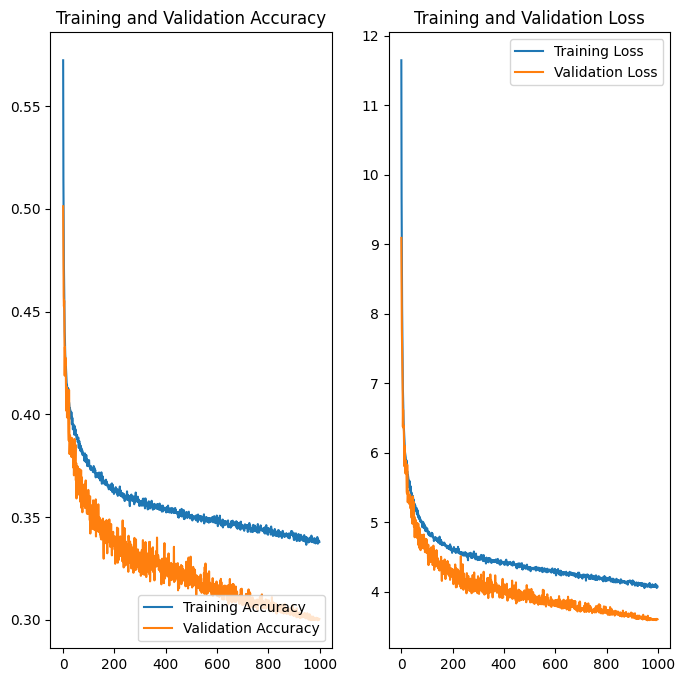

In [28]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

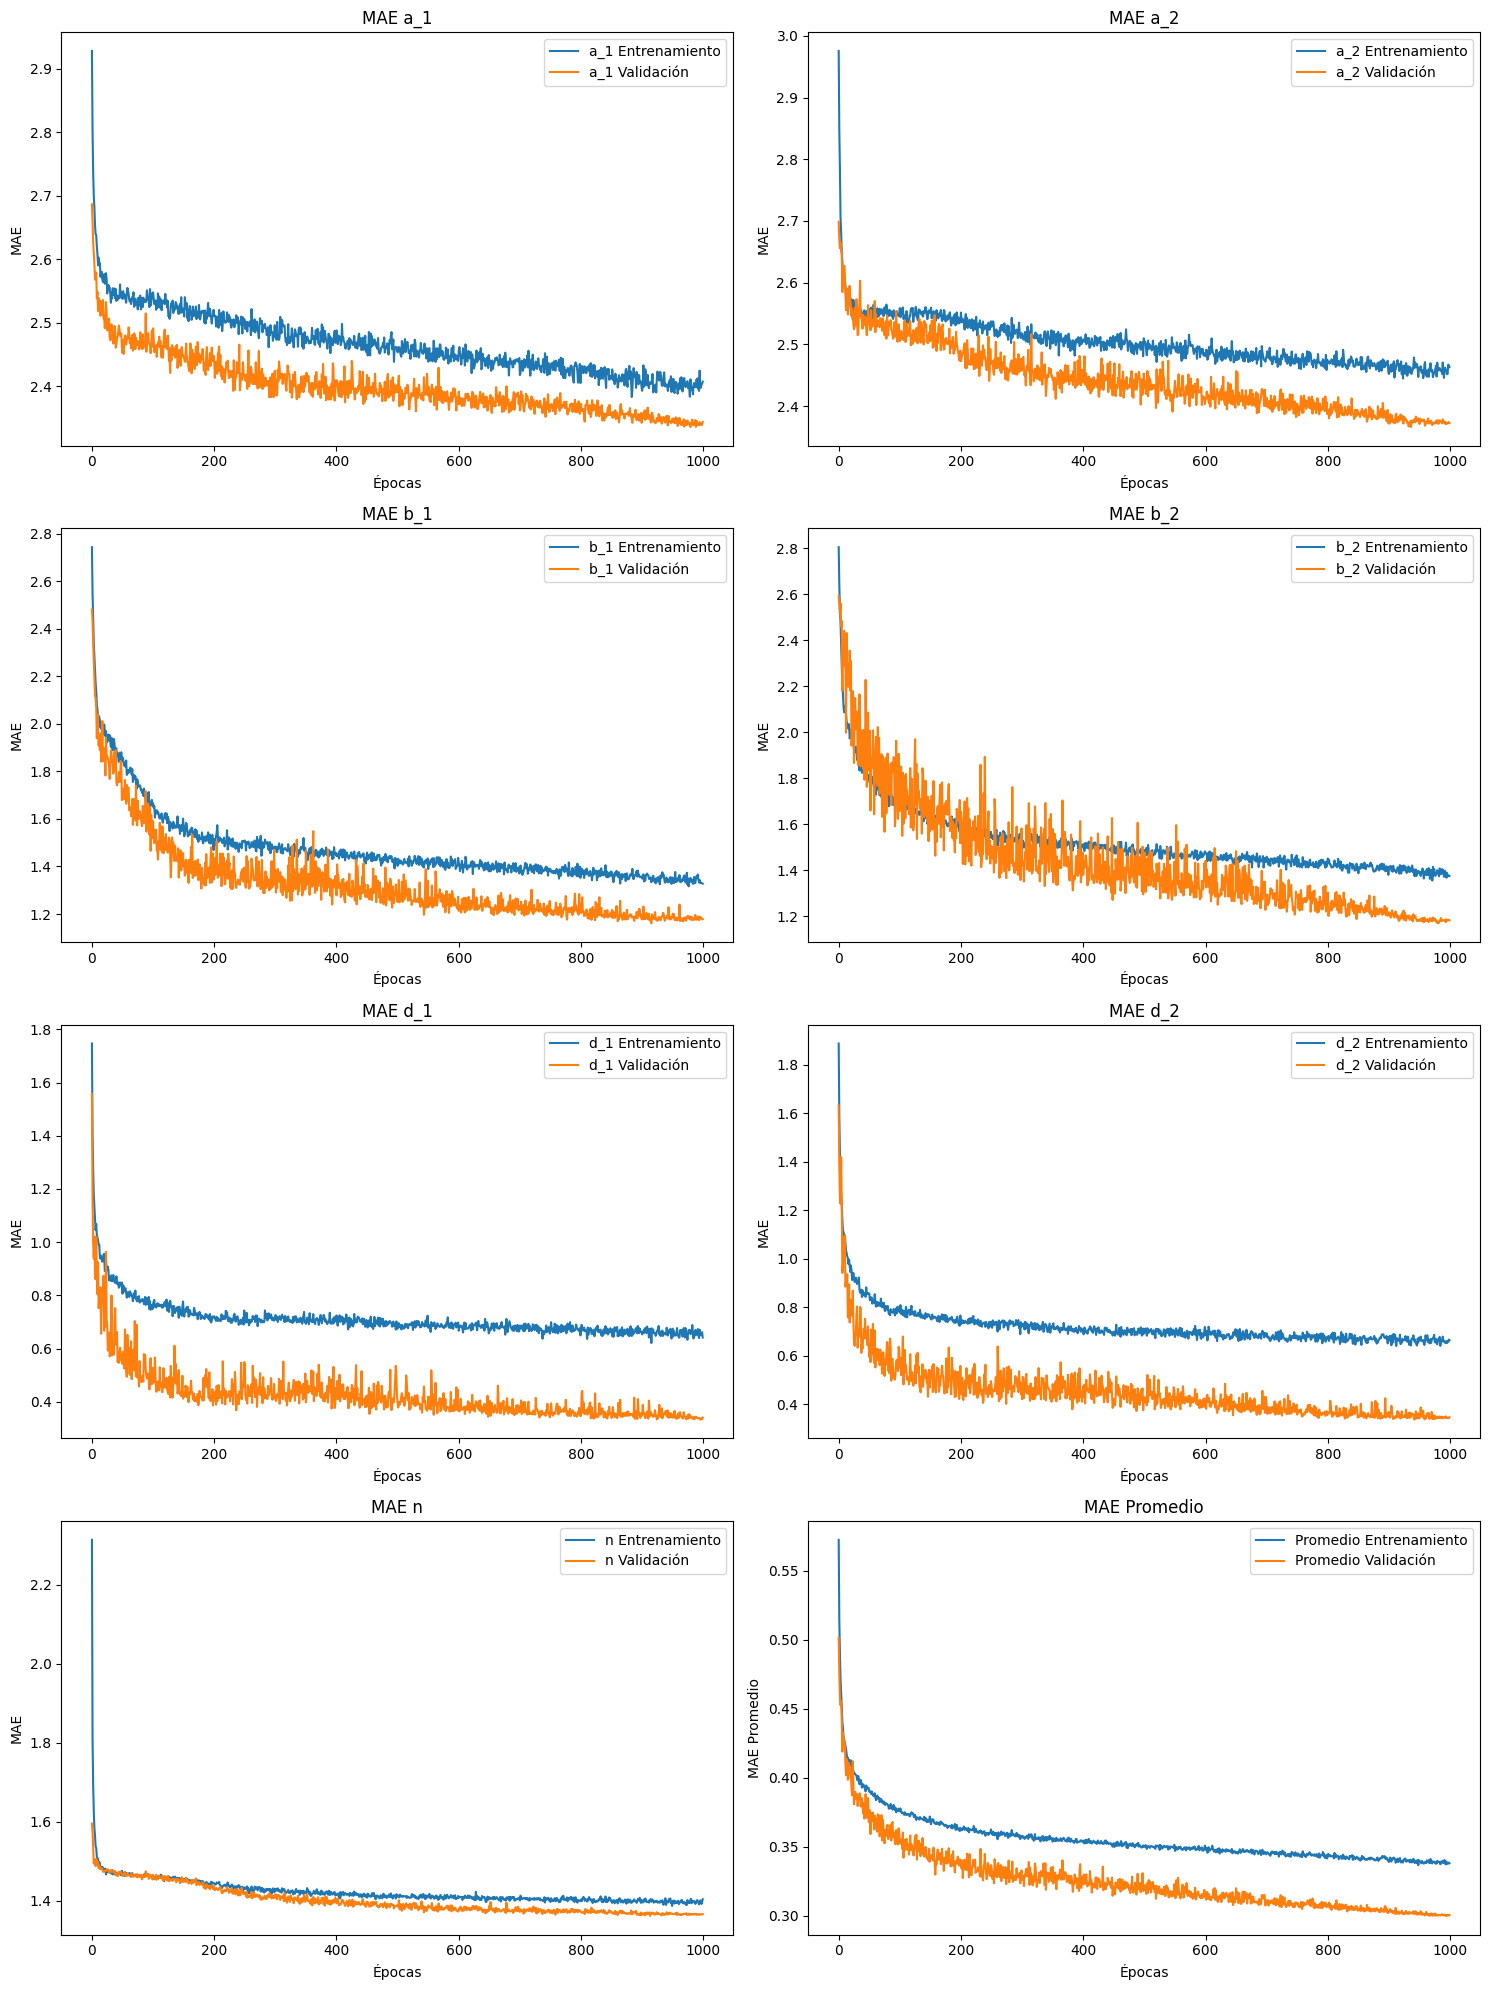

In [29]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [30]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

32/32 [==============================] - 0s 763us/step - loss: 3.7187 - a_1: 2.4573 - a_2: 2.4009 - b_1: 1.2382 - b_2: 1.1307 - d_1: 0.3439 - d_2: 0.3201 - n: 1.3743 - mean_metric: 0.3104


In [31]:
predictions = model.predict(varftest)

32/32 [==============================] - 0s 636us/step


In [32]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.3249889064633418, Desviación estándar del error: 1.8676051152039024, Error absoluto máximo: 7.603428363800049


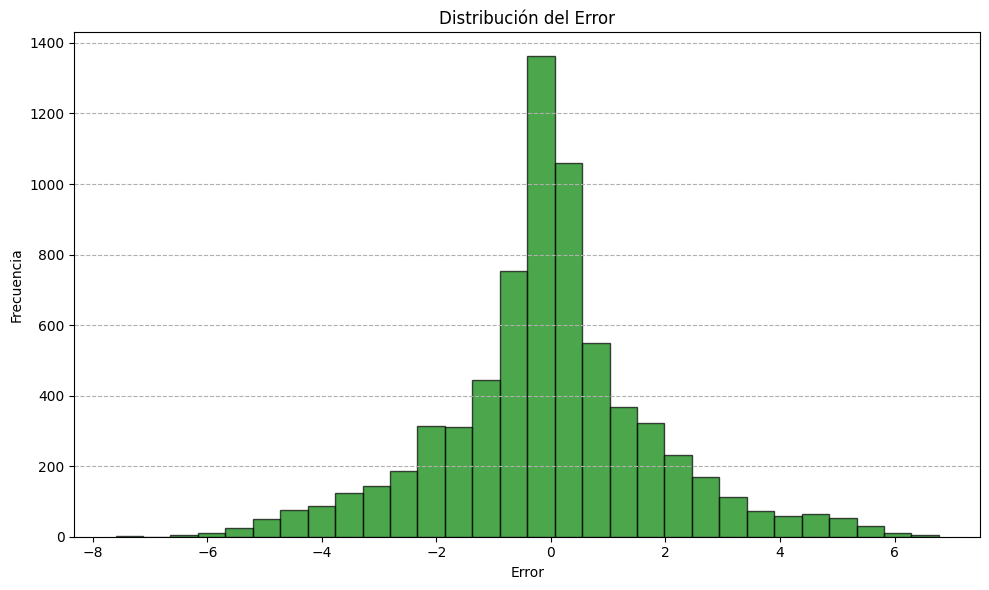

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [34]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.3115374390892335
Desviación estándar del error relativo: 0.18329116415836236
Error absoluto máximo relativo: 1.9836334032671792


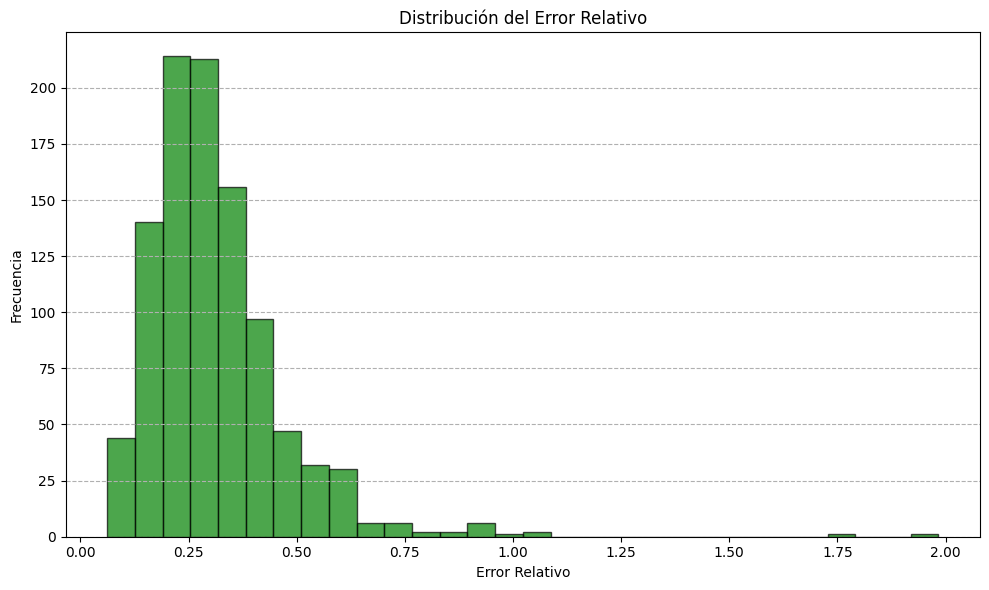

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()


# Guardamos los datos Accuracy y Loss

In [37]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 20,50/historytrayec50.csv', index=False)

# Guardamos el modelo

In [38]:
path_to_save = '../../..//Modelos/Modelos 20,50'

In [39]:
model.save(path_to_save + '/trayectorias50.h5')

# Importamos el modelo

In [40]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [41]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [42]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos/Modelos 20,50/trayectorias50.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [43]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 50)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[2, 10, 4, 2, 10, 3, 1]
(10, 2, 50)


In [44]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [45]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 50ms/step
[[ 5.  6.  5.  5. 10.  4.  3.]]


In [46]:
one_dim_array = new_predictions.flatten()

In [47]:
from sklearn.metrics import mean_absolute_error

# Asegúrate de que coef1 y new_predictions son ambos arrays de numpy o listas con el mismo tamaño
mae = mean_absolute_error(coef1, one_dim_array)

print("El Mean Absolute Error es:", mae)

El Mean Absolute Error es: 2.0


## Graficamos con los coeficientes reales

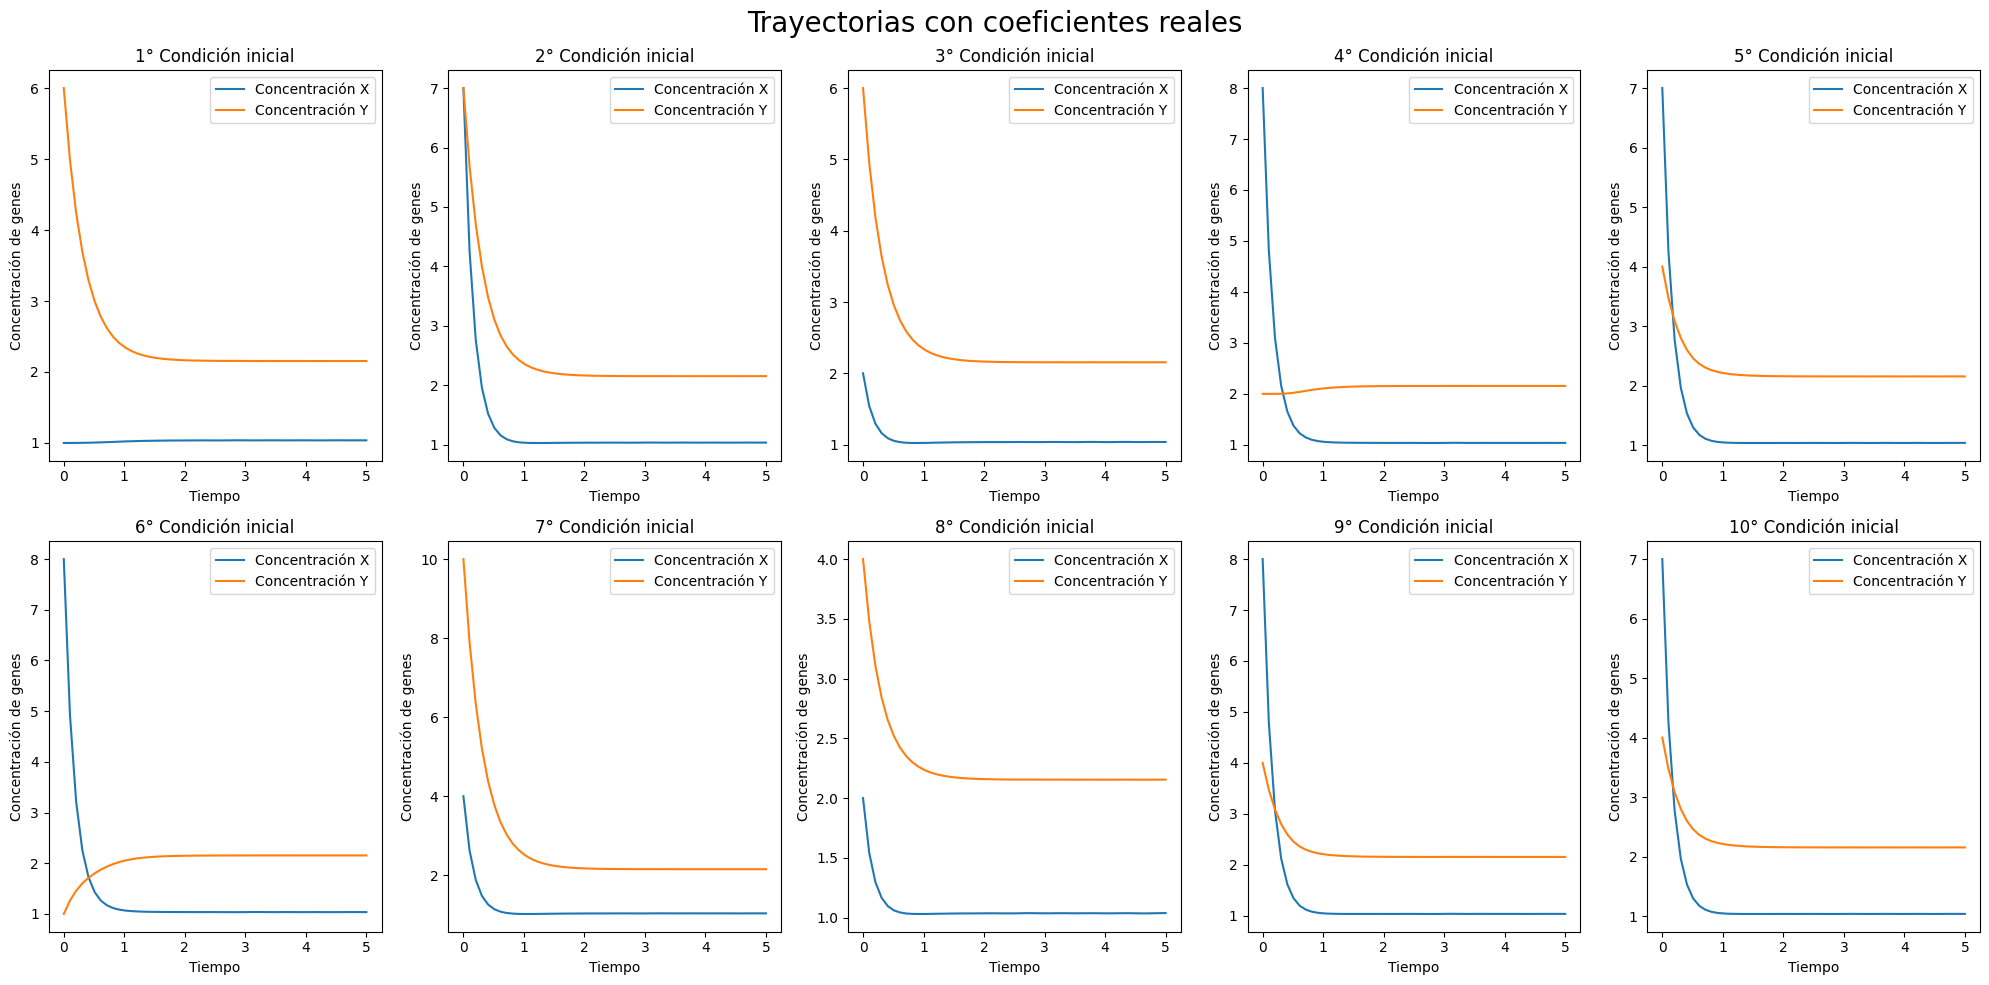

In [106]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [107]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

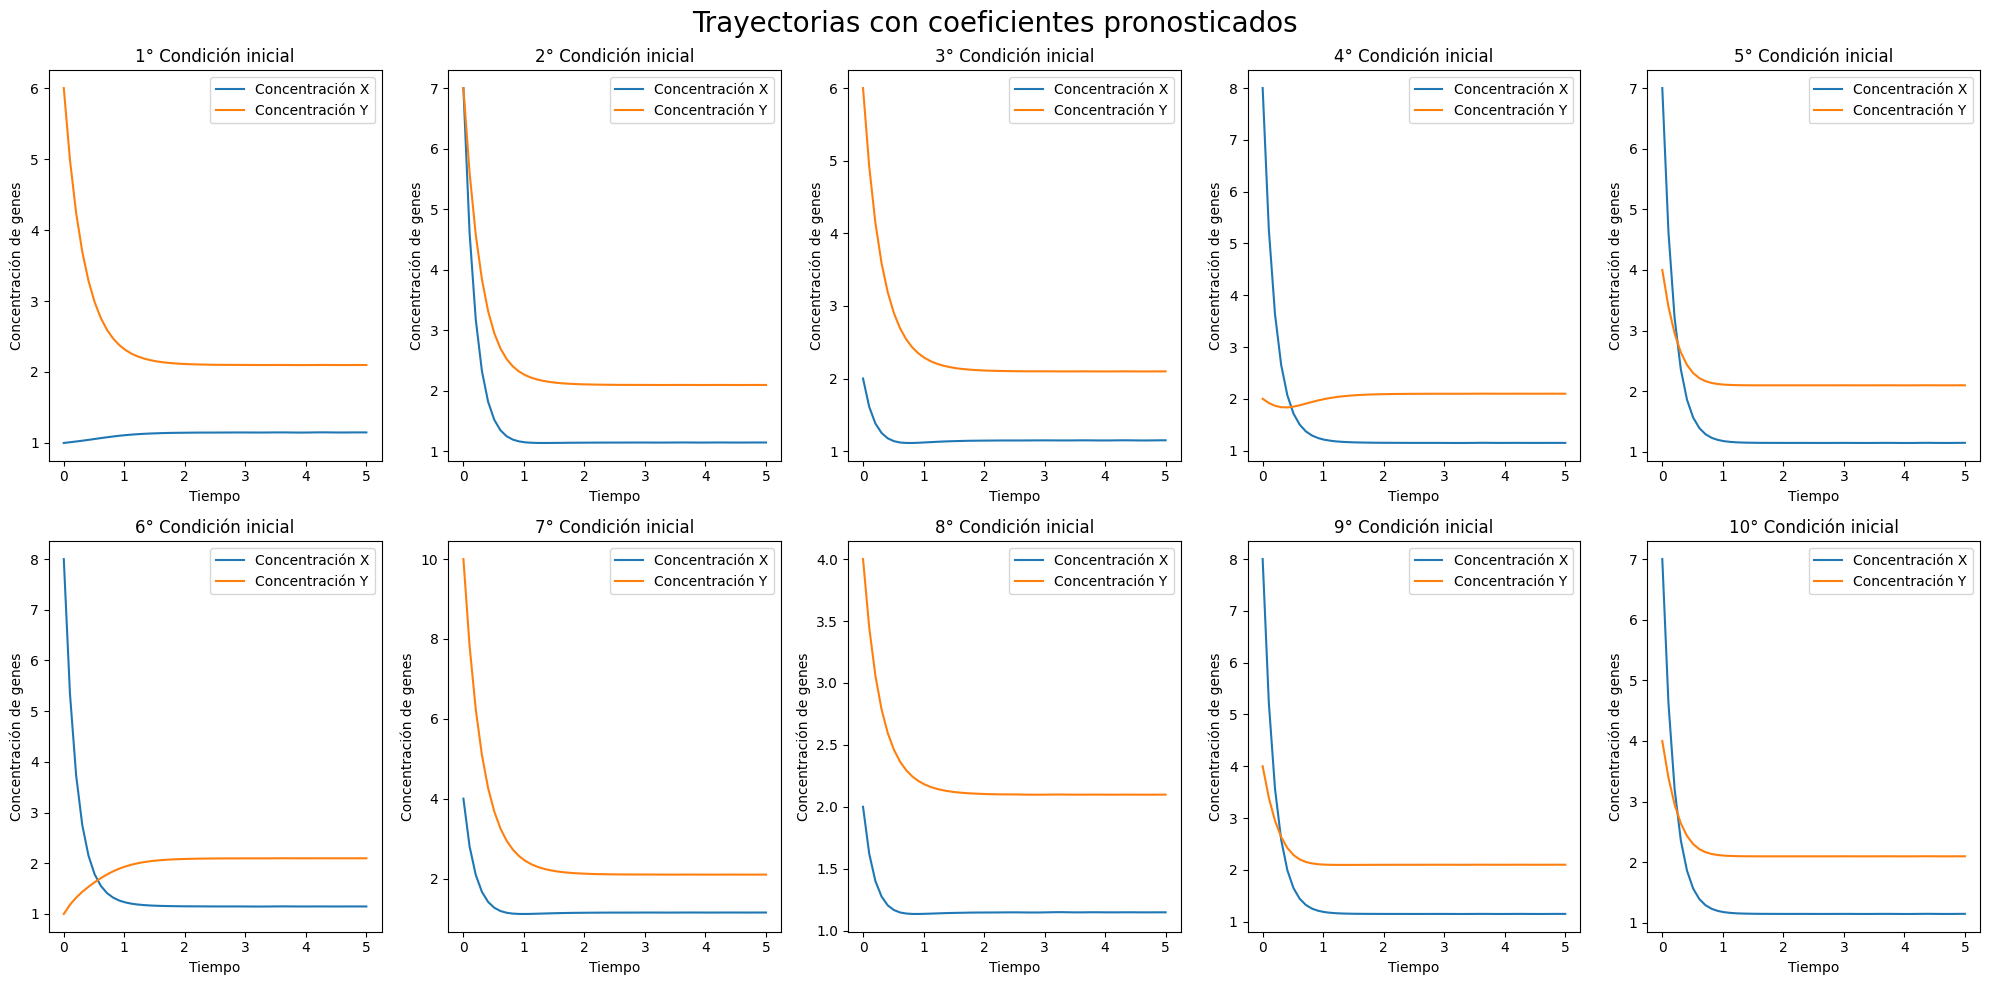

In [108]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

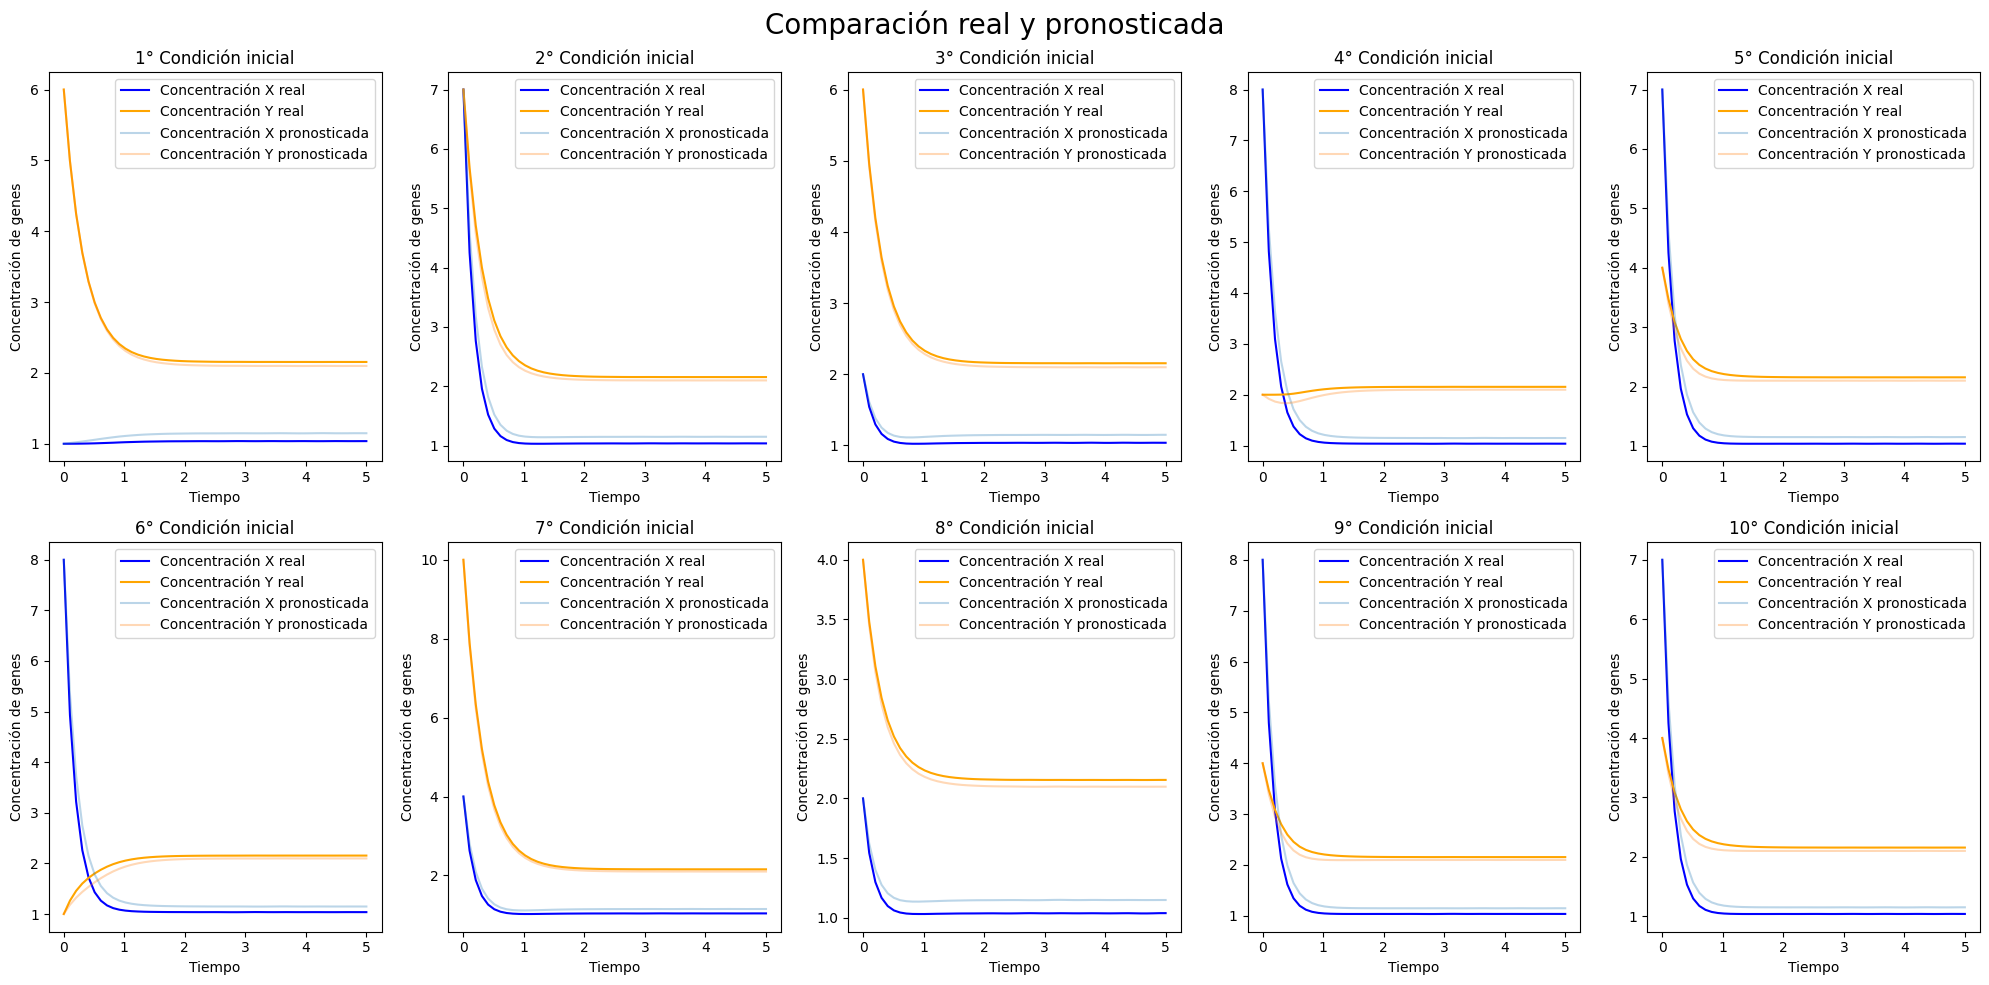

In [109]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

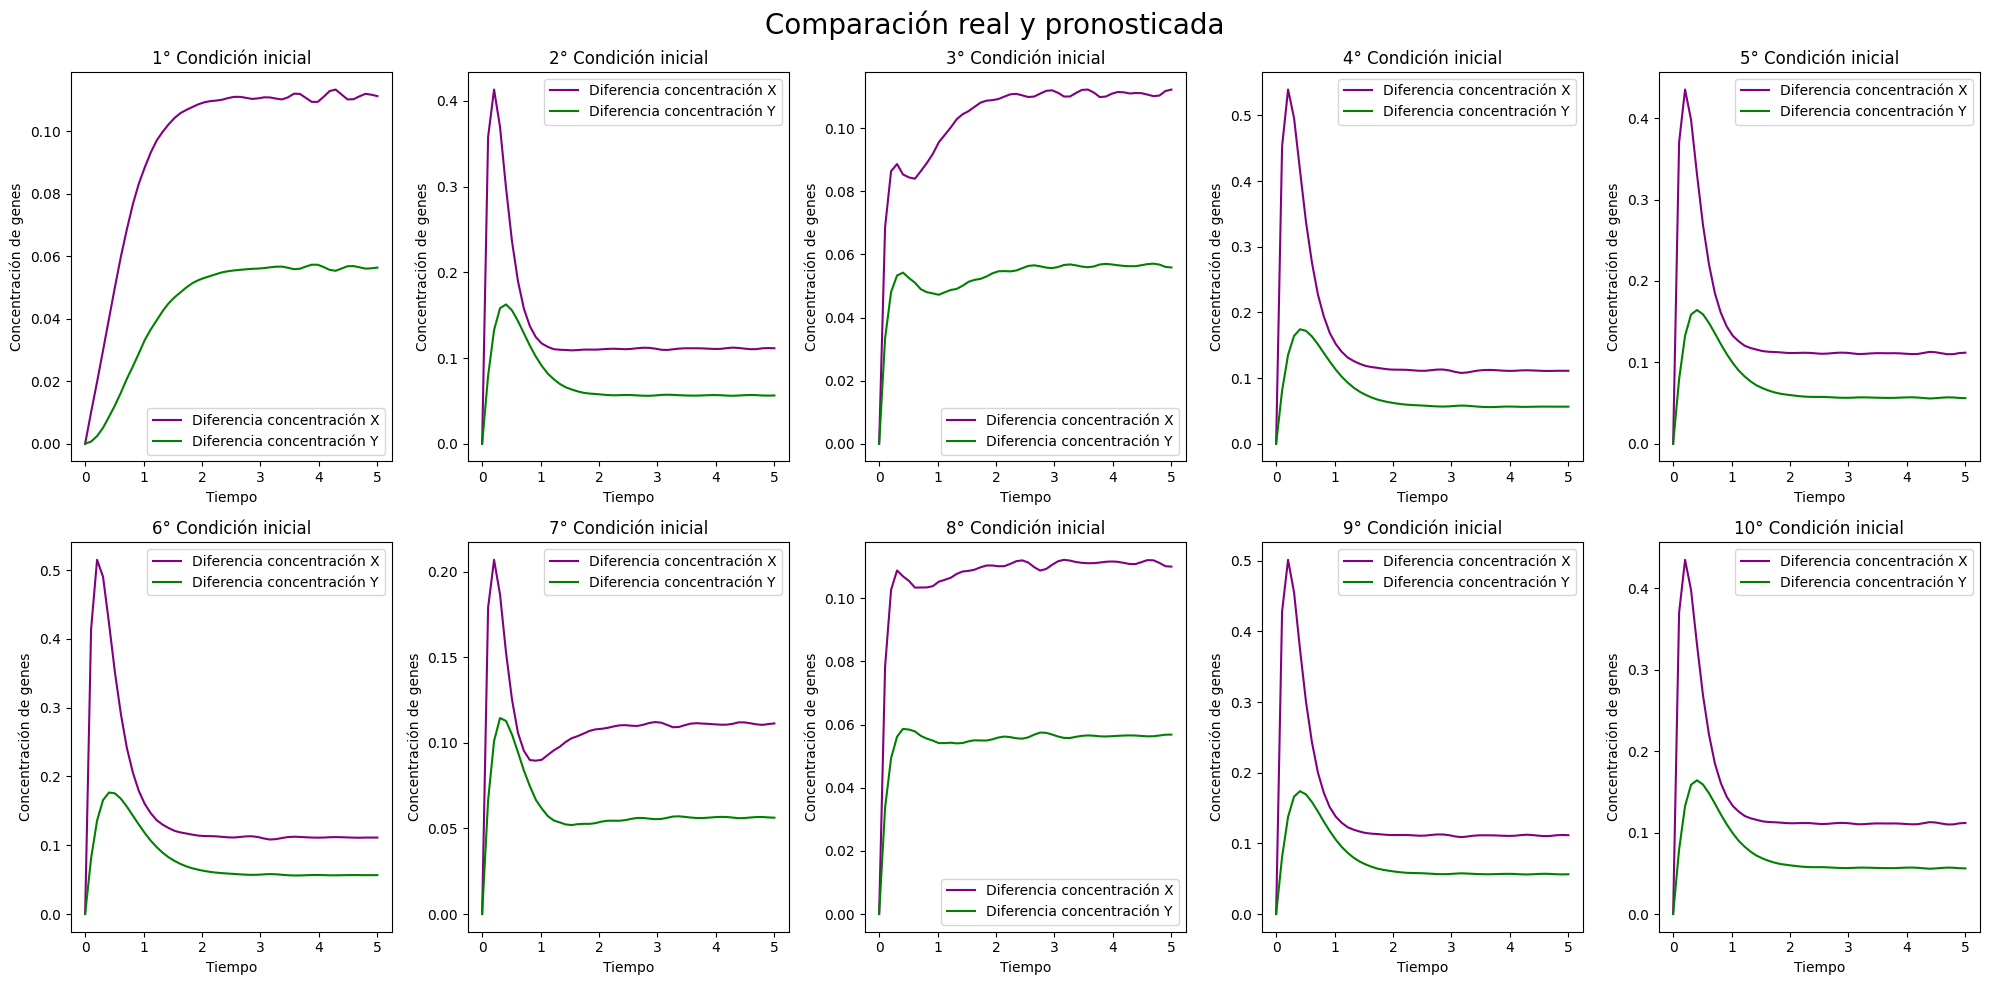

In [110]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.abs(np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :])
    diff_Y = np.abs(np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :])
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [111]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.03218202817003107
0.01649589166196283
